# Chap 7. Energy-Based Models

----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----


In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)


import random
import os
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

## 1. Data

2025-05-08 12:33:27.996275: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-08 12:33:27.996301: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-08 12:33:27.996309: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-08 12:33:27.996350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-08 12:33:27.996368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


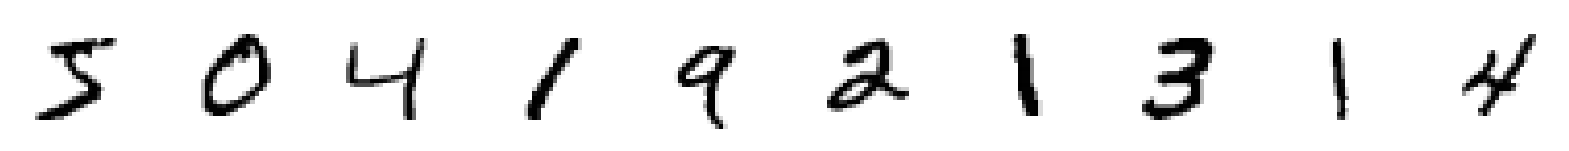

In [4]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)


# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)


## 2. EBM Network Model

In [5]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

if LOAD_MODEL:
    model.load_weights("./models/model.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

## 3. A Langevin sampler function

In [6]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 4. Buffer to stroe examples

In [7]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [8]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [9]:
ebm = EBM()

## 4. Train EMB Network

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0479 - reg: 0.0179 - cdiv: -0.0659 - real: 0.2468 - fake: 0.1809
Saved to ./temp/output/generated_img_000.png


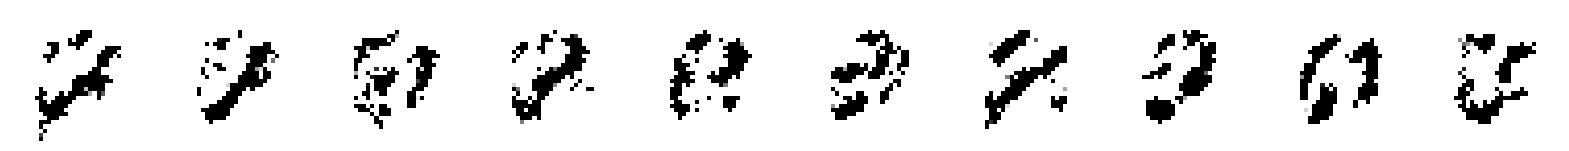


Saved to ./temp/output/example_img_000.png


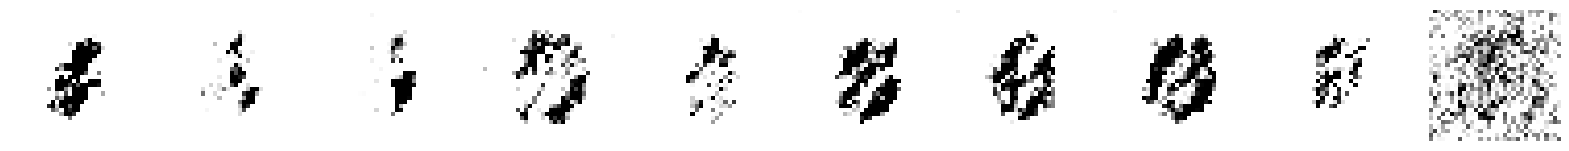

469/469 [==============================] - 343s 730ms/step - loss: -0.0479 - reg: 0.0179 - cdiv: -0.0659 - real: 0.2468 - fake: 0.1809 - val_cdiv: -1.6200 - val_real: -0.0126 - val_fake: -1.6326
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0047 - reg: 0.0028 - cdiv: -0.0075 - real: 0.0135 - fake: 0.0059
Saved to ./temp/output/generated_img_001.png


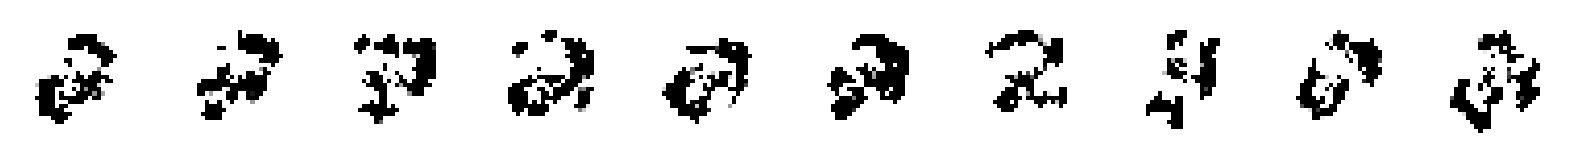


Saved to ./temp/output/example_img_001.png


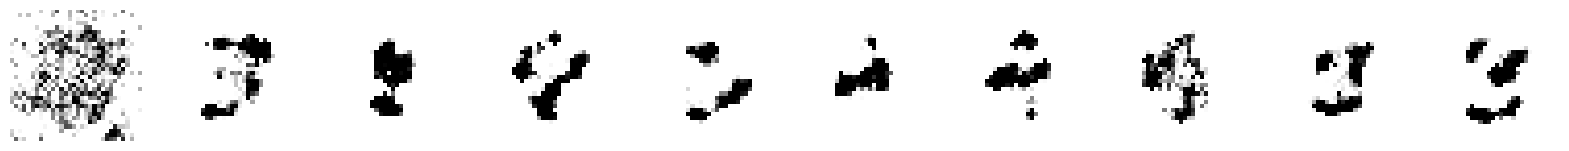

469/469 [==============================] - 356s 759ms/step - loss: -0.0047 - reg: 0.0028 - cdiv: -0.0075 - real: 0.0135 - fake: 0.0059 - val_cdiv: -1.9692 - val_real: -0.0872 - val_fake: -2.0564
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0028 - reg: 0.0017 - cdiv: -0.0045 - real: 0.0065 - fake: 0.0021
Saved to ./temp/output/generated_img_002.png


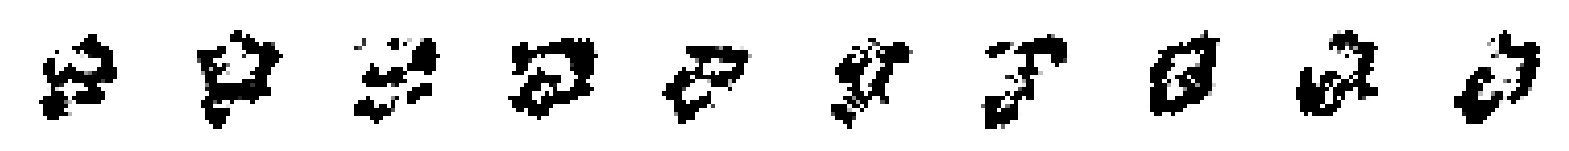


Saved to ./temp/output/example_img_002.png


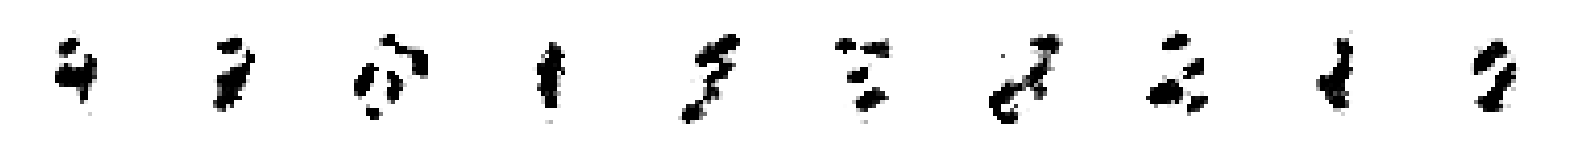

469/469 [==============================] - 348s 741ms/step - loss: -0.0028 - reg: 0.0017 - cdiv: -0.0045 - real: 0.0065 - fake: 0.0021 - val_cdiv: -2.4637 - val_real: -0.0313 - val_fake: -2.4951
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: 4.4328e-04 - reg: 8.0354e-04 - cdiv: -3.6026e-04 - real: 0.0025 - fake: 0.0021
Saved to ./temp/output/generated_img_003.png


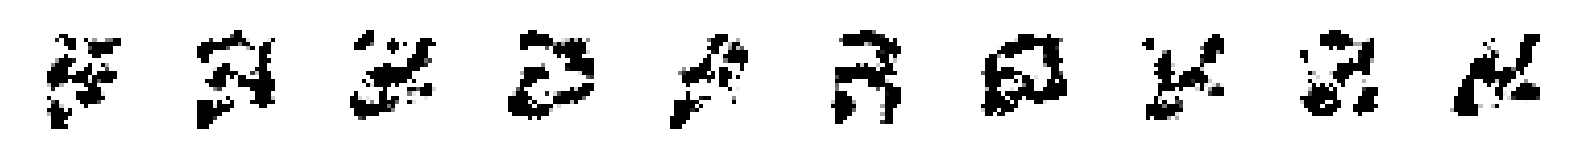


Saved to ./temp/output/example_img_003.png


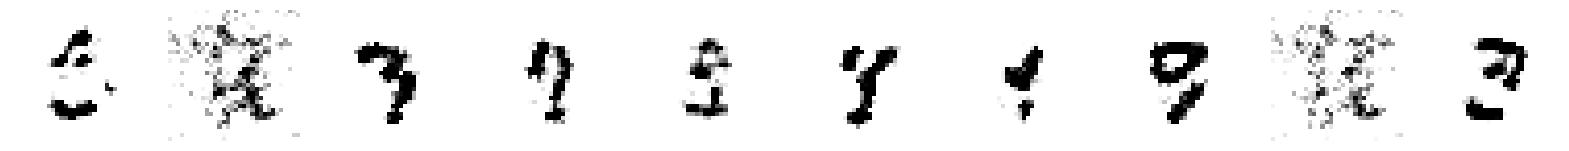

469/469 [==============================] - 342s 728ms/step - loss: 4.4328e-04 - reg: 8.0354e-04 - cdiv: -3.6026e-04 - real: 0.0025 - fake: 0.0021 - val_cdiv: -2.6730 - val_real: -0.0422 - val_fake: -2.7152
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: -3.3348e-04 - reg: 5.5266e-04 - cdiv: -8.8615e-04 - real: 0.0023 - fake: 0.0014
Saved to ./temp/output/generated_img_004.png


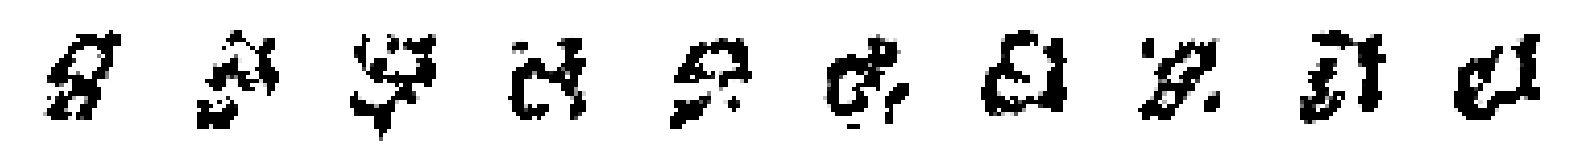


Saved to ./temp/output/example_img_004.png


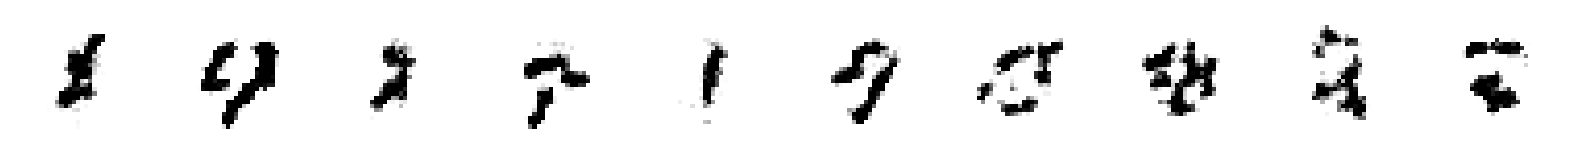

469/469 [==============================] - 337s 719ms/step - loss: -3.3348e-04 - reg: 5.5266e-04 - cdiv: -8.8615e-04 - real: 0.0023 - fake: 0.0014 - val_cdiv: -3.0960 - val_real: -0.0389 - val_fake: -3.1349
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 2.9685e-04 - reg: 4.2934e-04 - cdiv: -1.3249e-04 - real: 0.0020 - fake: 0.0019
Saved to ./temp/output/generated_img_005.png


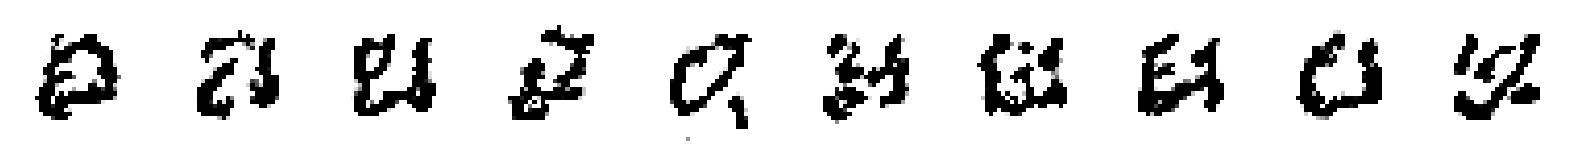


Saved to ./temp/output/example_img_005.png


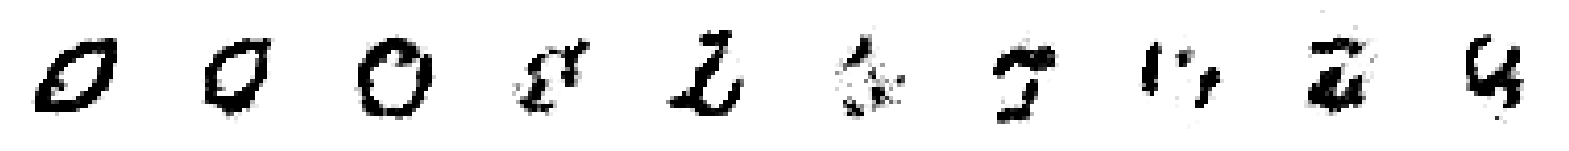

469/469 [==============================] - 342s 730ms/step - loss: 2.9685e-04 - reg: 4.2934e-04 - cdiv: -1.3249e-04 - real: 0.0020 - fake: 0.0019 - val_cdiv: -3.5413 - val_real: -0.0300 - val_fake: -3.5713
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 3.0533e-06 - reg: 4.1159e-04 - cdiv: -4.0854e-04 - real: 0.0017 - fake: 0.0013 
Saved to ./temp/output/generated_img_006.png


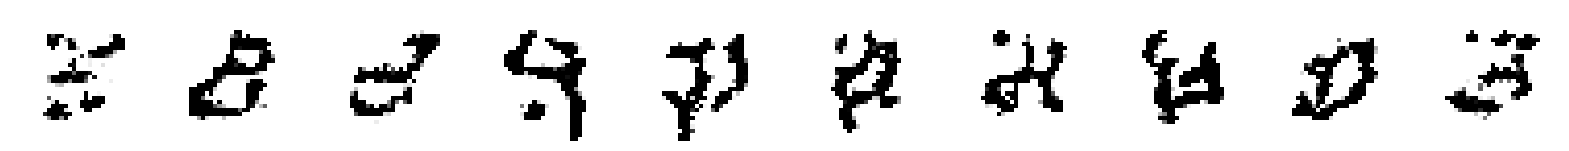


Saved to ./temp/output/example_img_006.png


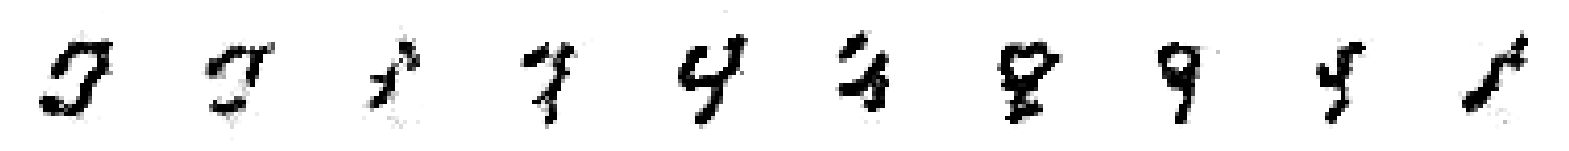

469/469 [==============================] - 351s 748ms/step - loss: 3.0533e-06 - reg: 4.1159e-04 - cdiv: -4.0854e-04 - real: 0.0017 - fake: 0.0013 - val_cdiv: -4.0175 - val_real: -0.0461 - val_fake: -4.0637
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 3.1808e-04 - reg: 4.5426e-04 - cdiv: -1.3618e-04 - real: 0.0020 - fake: 0.0019
Saved to ./temp/output/generated_img_007.png


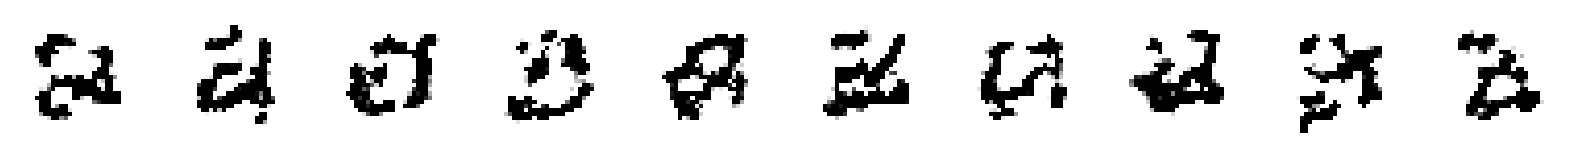


Saved to ./temp/output/example_img_007.png


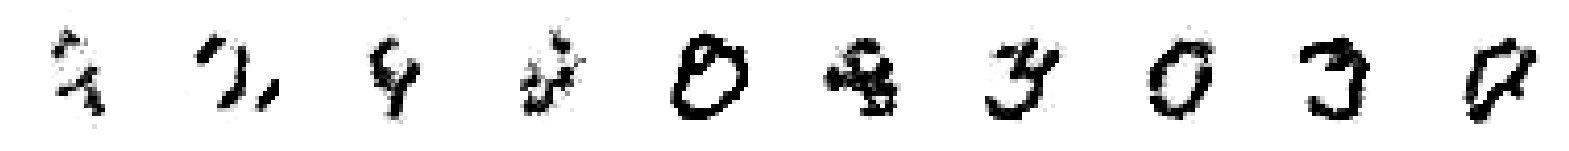

469/469 [==============================] - 350s 746ms/step - loss: 3.1808e-04 - reg: 4.5426e-04 - cdiv: -1.3618e-04 - real: 0.0020 - fake: 0.0019 - val_cdiv: -4.4516 - val_real: -0.0370 - val_fake: -4.4886
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: -5.0709e-04 - reg: 4.6190e-04 - cdiv: -9.6900e-04 - real: 0.0017 - fake: 7.7152e-04
Saved to ./temp/output/generated_img_008.png


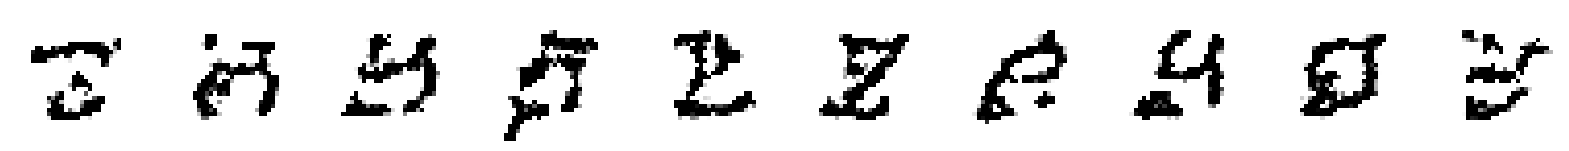


Saved to ./temp/output/example_img_008.png


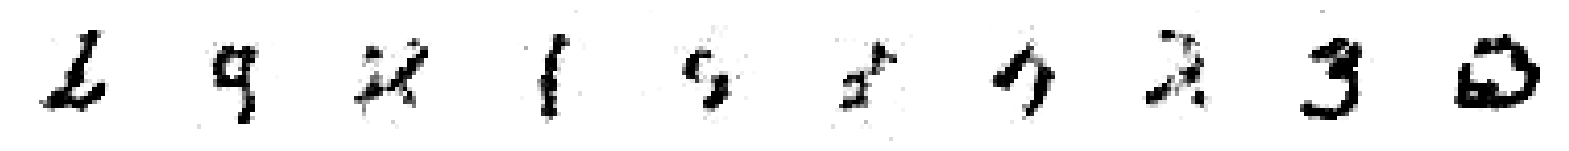

469/469 [==============================] - 349s 744ms/step - loss: -5.0709e-04 - reg: 4.6190e-04 - cdiv: -9.6900e-04 - real: 0.0017 - fake: 7.7152e-04 - val_cdiv: -5.0995 - val_real: -0.0298 - val_fake: -5.1293
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: -6.2601e-04 - reg: 4.5286e-04 - cdiv: -0.0011 - real: 0.0021 - fake: 9.7252e-04
Saved to ./temp/output/generated_img_009.png


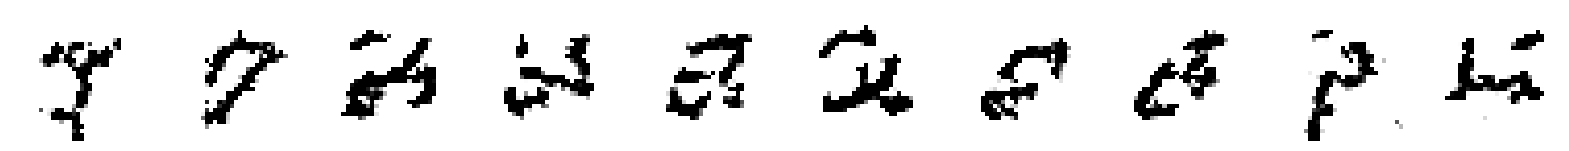


Saved to ./temp/output/example_img_009.png


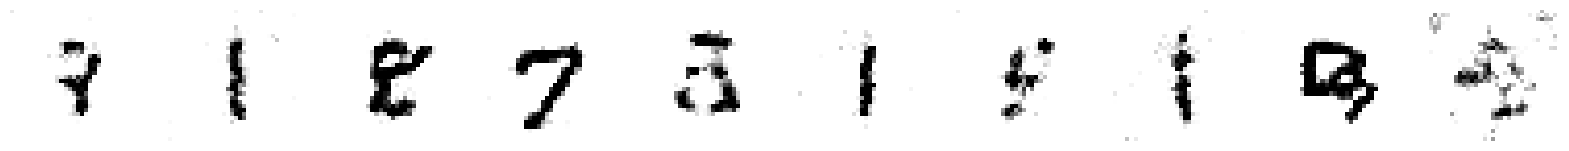

469/469 [==============================] - 349s 744ms/step - loss: -6.2601e-04 - reg: 4.5286e-04 - cdiv: -0.0011 - real: 0.0021 - fake: 9.7252e-04 - val_cdiv: -5.8658 - val_real: -0.0174 - val_fake: -5.8833
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: -1.2197e-05 - reg: 4.3910e-04 - cdiv: -4.5130e-04 - real: 0.0019 - fake: 0.0015
Saved to ./temp/output/generated_img_010.png


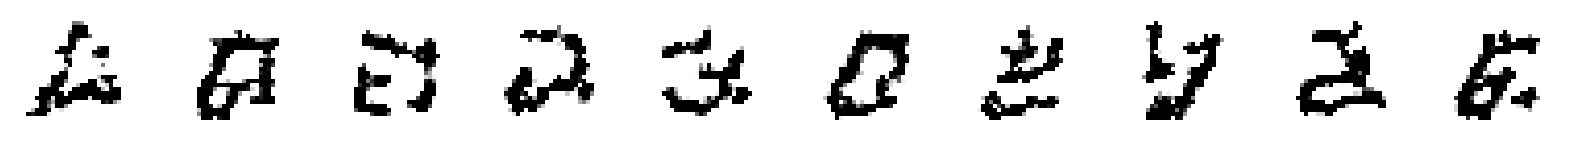


Saved to ./temp/output/example_img_010.png


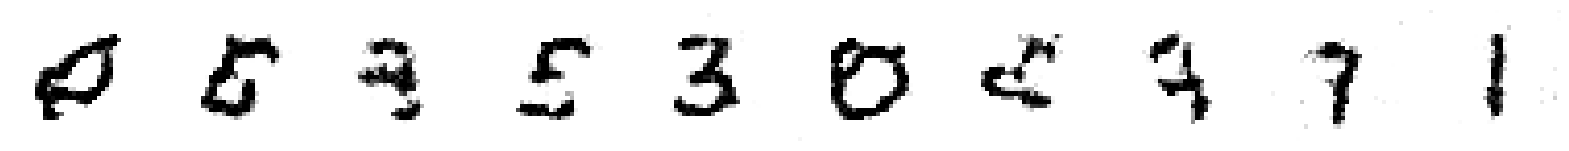

469/469 [==============================] - 345s 735ms/step - loss: -1.2197e-05 - reg: 4.3910e-04 - cdiv: -4.5130e-04 - real: 0.0019 - fake: 0.0015 - val_cdiv: -6.3681 - val_real: -0.0188 - val_fake: -6.3869
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: -1.7774e-04 - reg: 3.5485e-04 - cdiv: -5.3259e-04 - real: 0.0014 - fake: 8.4180e-04
Saved to ./temp/output/generated_img_011.png


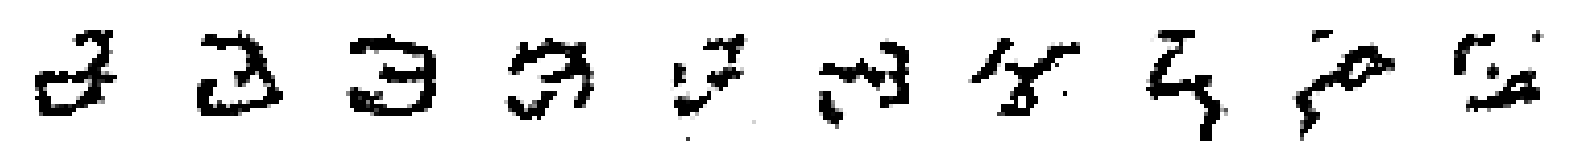


Saved to ./temp/output/example_img_011.png


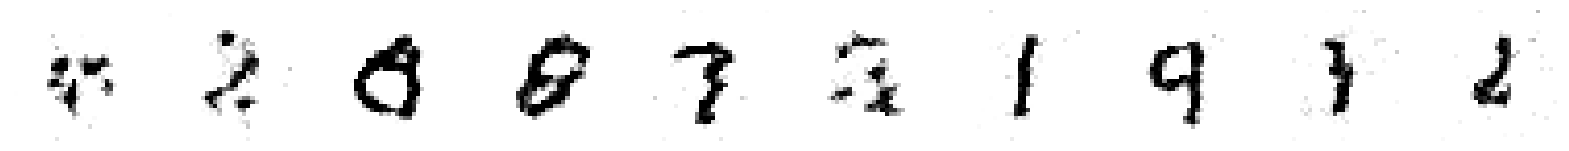

469/469 [==============================] - 341s 727ms/step - loss: -1.7774e-04 - reg: 3.5485e-04 - cdiv: -5.3259e-04 - real: 0.0014 - fake: 8.4180e-04 - val_cdiv: -6.9762 - val_real: -0.0350 - val_fake: -7.0112
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: -3.0363e-04 - reg: 4.2814e-04 - cdiv: -7.3177e-04 - real: 0.0018 - fake: 0.0011
Saved to ./temp/output/generated_img_012.png


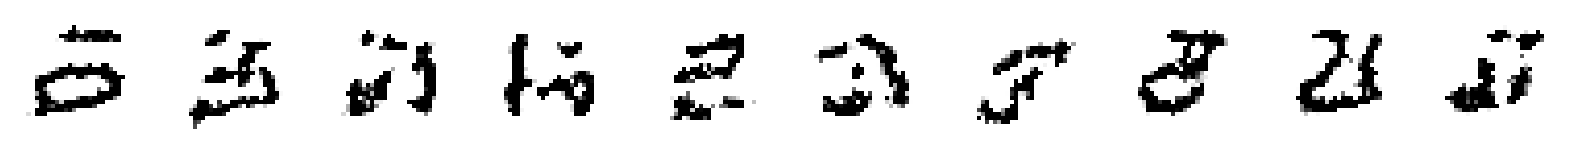


Saved to ./temp/output/example_img_012.png


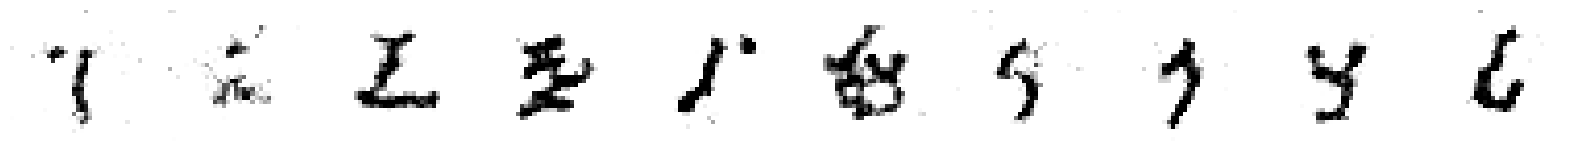

469/469 [==============================] - 342s 728ms/step - loss: -3.0363e-04 - reg: 4.2814e-04 - cdiv: -7.3177e-04 - real: 0.0018 - fake: 0.0011 - val_cdiv: -7.6860 - val_real: -0.0026 - val_fake: -7.6886
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: -2.9848e-05 - reg: 3.9512e-04 - cdiv: -4.2497e-04 - real: 0.0014 - fake: 9.3183e-04
Saved to ./temp/output/generated_img_013.png


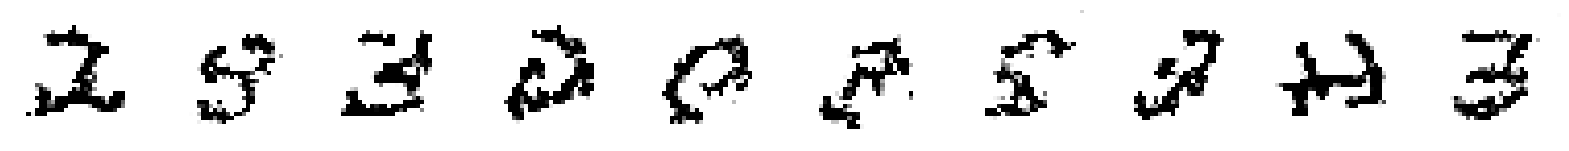


Saved to ./temp/output/example_img_013.png


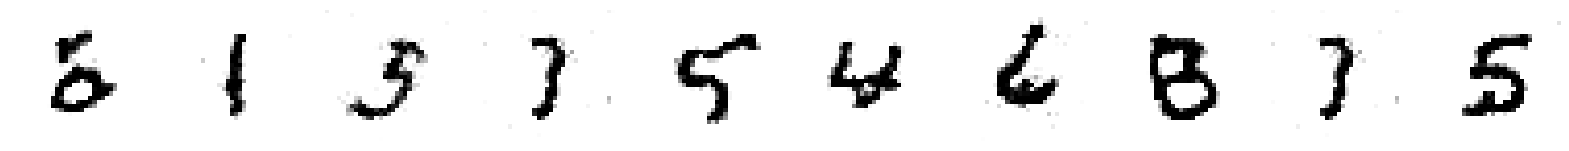

469/469 [==============================] - 341s 728ms/step - loss: -2.9848e-05 - reg: 3.9512e-04 - cdiv: -4.2497e-04 - real: 0.0014 - fake: 9.3183e-04 - val_cdiv: -8.1691 - val_real: 0.0142 - val_fake: -8.1549
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: -4.0965e-04 - reg: 3.5238e-04 - cdiv: -7.6203e-04 - real: 0.0017 - fake: 8.9962e-04
Saved to ./temp/output/generated_img_014.png


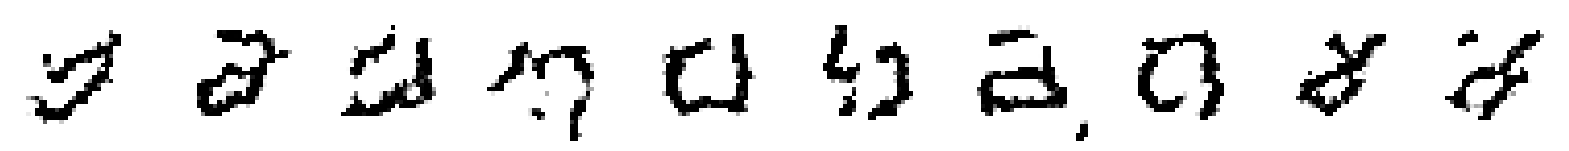


Saved to ./temp/output/example_img_014.png


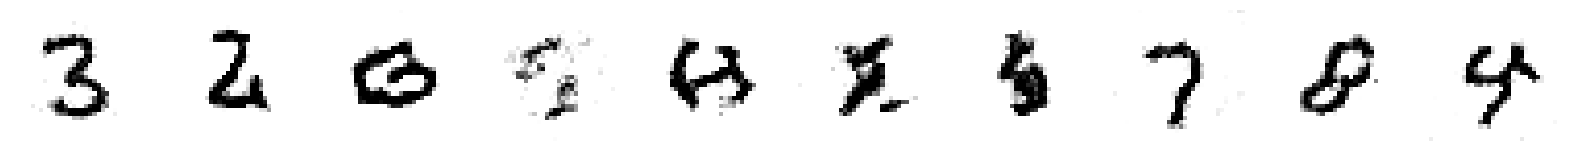

469/469 [==============================] - 341s 726ms/step - loss: -4.0965e-04 - reg: 3.5238e-04 - cdiv: -7.6203e-04 - real: 0.0017 - fake: 8.9962e-04 - val_cdiv: -8.8888 - val_real: -0.0092 - val_fake: -8.8980
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: 2.8404e-04 - reg: 3.3090e-04 - cdiv: -4.6857e-05 - real: 0.0015 - fake: 0.0015
Saved to ./temp/output/generated_img_015.png


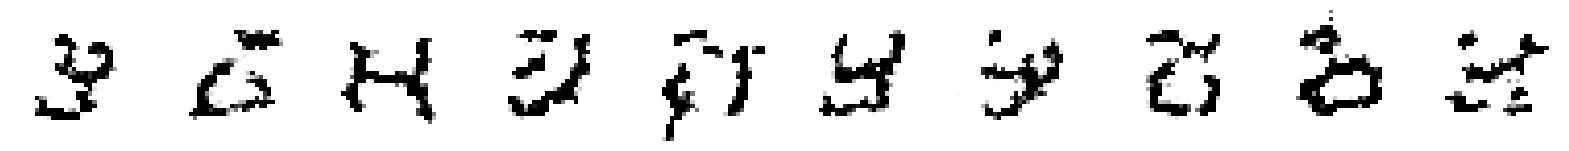


Saved to ./temp/output/example_img_015.png


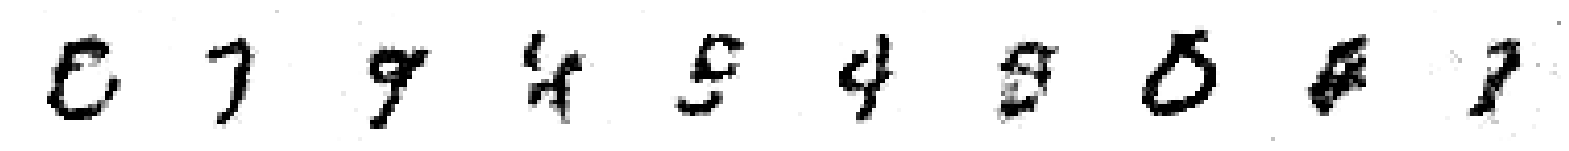

469/469 [==============================] - 341s 727ms/step - loss: 2.8404e-04 - reg: 3.3090e-04 - cdiv: -4.6857e-05 - real: 0.0015 - fake: 0.0015 - val_cdiv: -9.3095 - val_real: -0.0135 - val_fake: -9.3230
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: -2.4589e-05 - reg: 2.7153e-04 - cdiv: -2.9612e-04 - real: 0.0010 - fake: 7.4984e-04
Saved to ./temp/output/generated_img_016.png


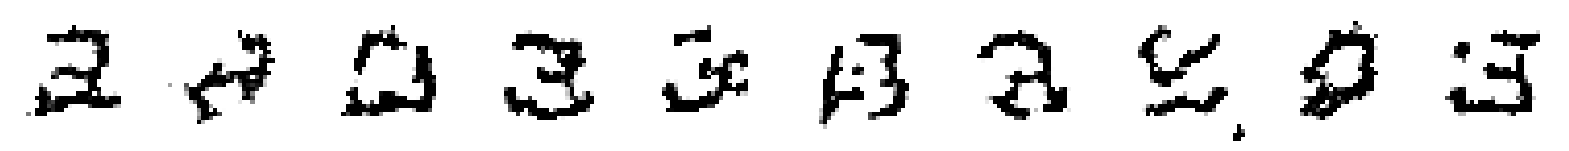


Saved to ./temp/output/example_img_016.png


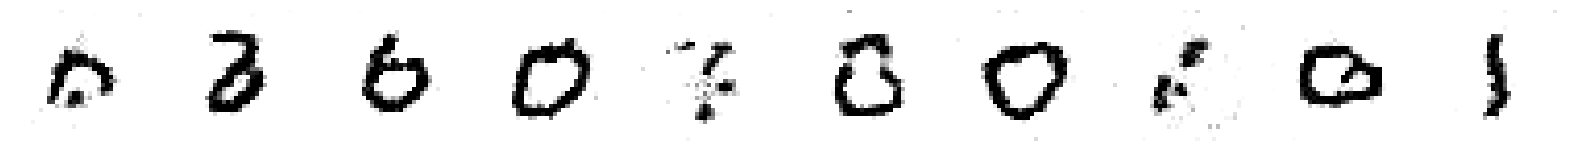

469/469 [==============================] - 342s 729ms/step - loss: -2.4589e-05 - reg: 2.7153e-04 - cdiv: -2.9612e-04 - real: 0.0010 - fake: 7.4984e-04 - val_cdiv: -9.7873 - val_real: -0.0118 - val_fake: -9.7991
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: -3.6709e-04 - reg: 3.0122e-04 - cdiv: -6.6832e-04 - real: 0.0012 - fake: 5.7065e-04
Saved to ./temp/output/generated_img_017.png


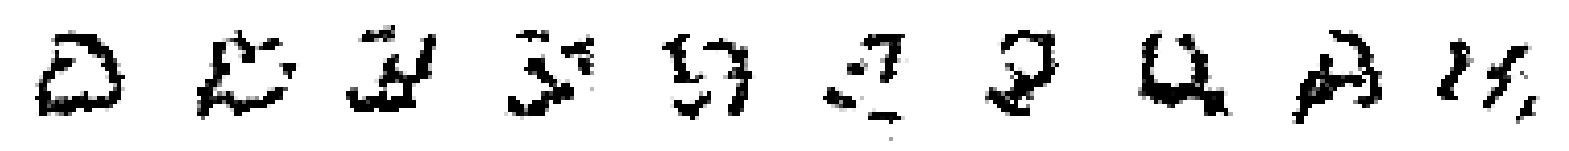


Saved to ./temp/output/example_img_017.png


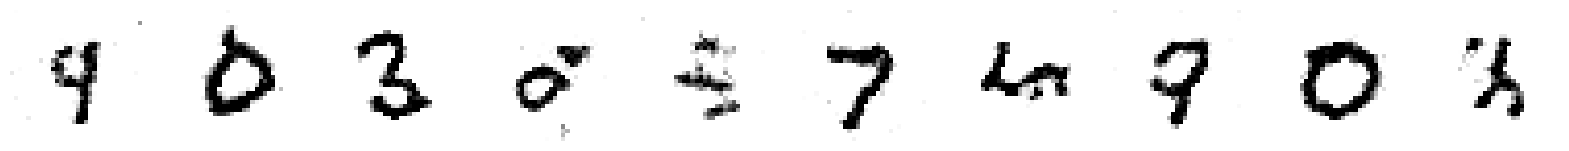

469/469 [==============================] - 341s 727ms/step - loss: -3.6709e-04 - reg: 3.0122e-04 - cdiv: -6.6832e-04 - real: 0.0012 - fake: 5.7065e-04 - val_cdiv: -10.6255 - val_real: -0.0175 - val_fake: -10.6430
Epoch 19/60
469/469 [==============================] - ETA: 0s - loss: 6.8709e-06 - reg: 3.7128e-04 - cdiv: -3.6441e-04 - real: 0.0014 - fake: 0.0011 
Saved to ./temp/output/generated_img_018.png


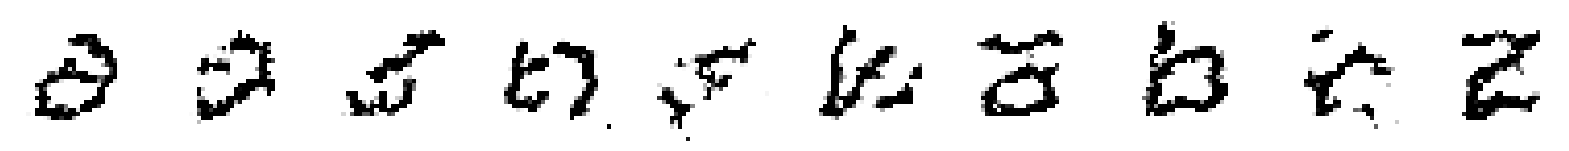


Saved to ./temp/output/example_img_018.png


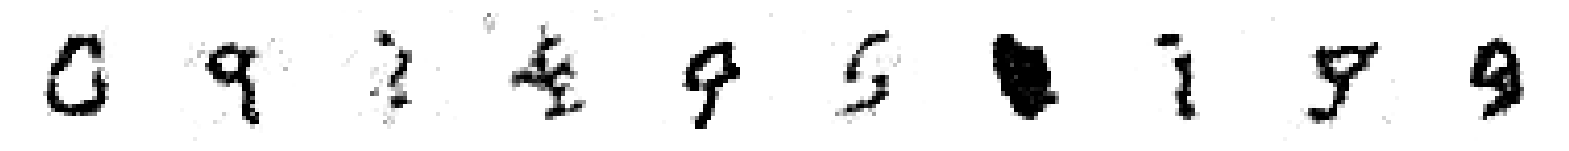

469/469 [==============================] - 342s 729ms/step - loss: 6.8709e-06 - reg: 3.7128e-04 - cdiv: -3.6441e-04 - real: 0.0014 - fake: 0.0011 - val_cdiv: -11.1351 - val_real: -0.0063 - val_fake: -11.1413
Epoch 20/60
469/469 [==============================] - ETA: 0s - loss: 1.6761e-04 - reg: 2.8885e-04 - cdiv: -1.2124e-04 - real: 0.0014 - fake: 0.0012
Saved to ./temp/output/generated_img_019.png


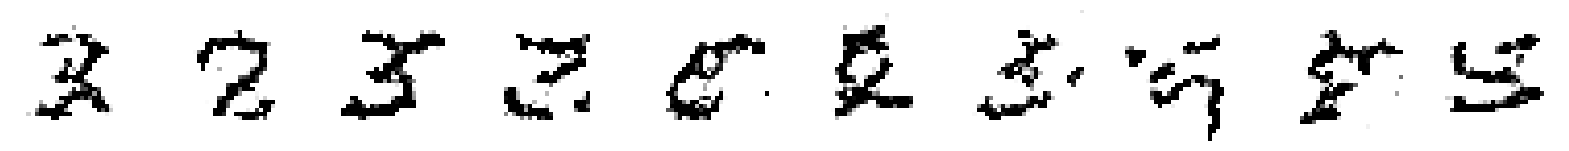


Saved to ./temp/output/example_img_019.png


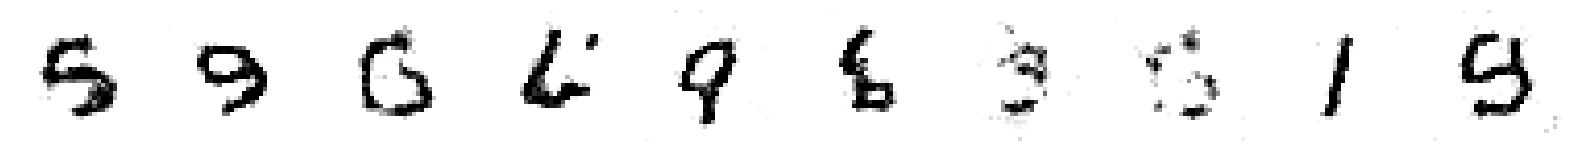

469/469 [==============================] - 346s 737ms/step - loss: 1.6761e-04 - reg: 2.8885e-04 - cdiv: -1.2124e-04 - real: 0.0014 - fake: 0.0012 - val_cdiv: -11.7148 - val_real: -3.1913e-04 - val_fake: -11.7151
Epoch 21/60
469/469 [==============================] - ETA: 0s - loss: -7.7995e-05 - reg: 2.5681e-04 - cdiv: -3.3480e-04 - real: 7.8348e-04 - fake: 4.4868e-04
Saved to ./temp/output/generated_img_020.png


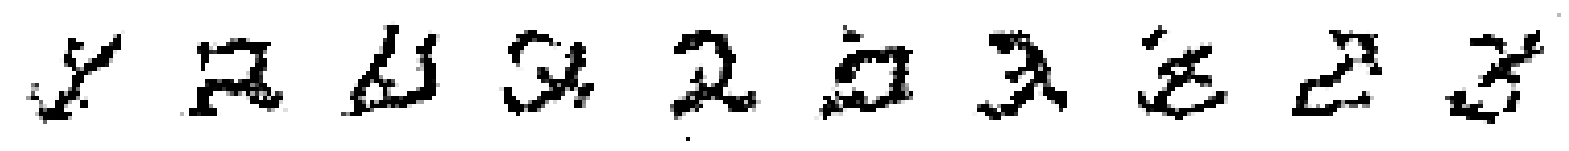


Saved to ./temp/output/example_img_020.png


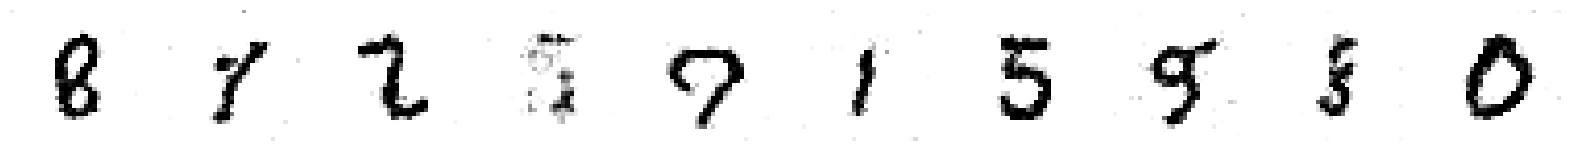

469/469 [==============================] - 349s 745ms/step - loss: -7.7995e-05 - reg: 2.5681e-04 - cdiv: -3.3480e-04 - real: 7.8348e-04 - fake: 4.4868e-04 - val_cdiv: -12.3501 - val_real: -0.0034 - val_fake: -12.3535
Epoch 22/60
469/469 [==============================] - ETA: 0s - loss: 3.2503e-04 - reg: 2.8179e-04 - cdiv: 4.3237e-05 - real: 0.0014 - fake: 0.0015
Saved to ./temp/output/generated_img_021.png


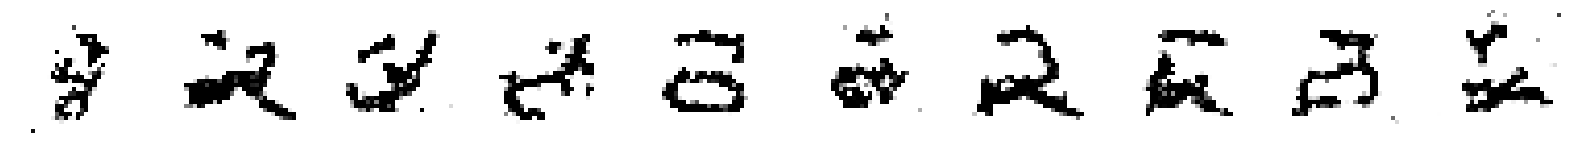


Saved to ./temp/output/example_img_021.png


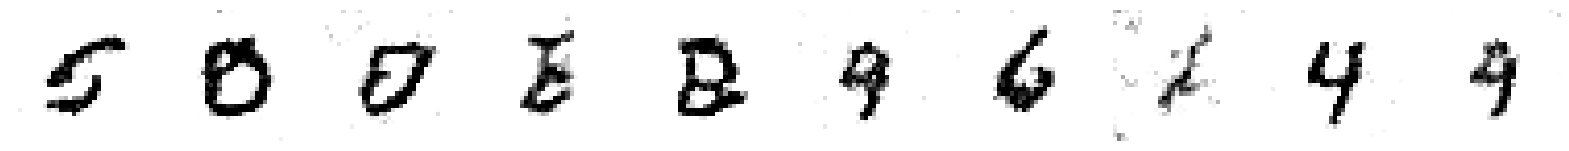

469/469 [==============================] - 352s 749ms/step - loss: 3.2503e-04 - reg: 2.8179e-04 - cdiv: 4.3237e-05 - real: 0.0014 - fake: 0.0015 - val_cdiv: -12.8331 - val_real: 0.0072 - val_fake: -12.8259
Epoch 23/60
469/469 [==============================] - ETA: 0s - loss: -2.6035e-05 - reg: 2.7408e-04 - cdiv: -3.0011e-04 - real: 7.0095e-04 - fake: 4.0084e-04
Saved to ./temp/output/generated_img_022.png


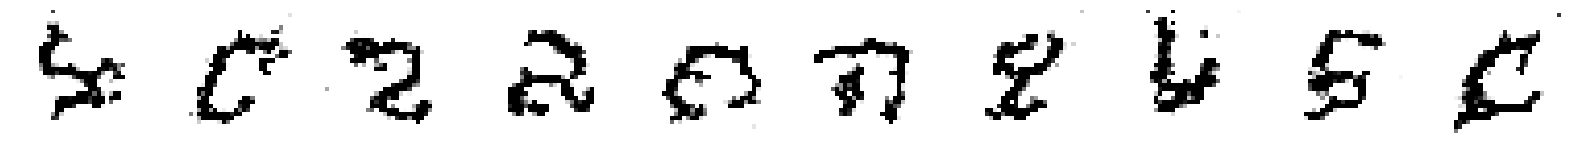


Saved to ./temp/output/example_img_022.png


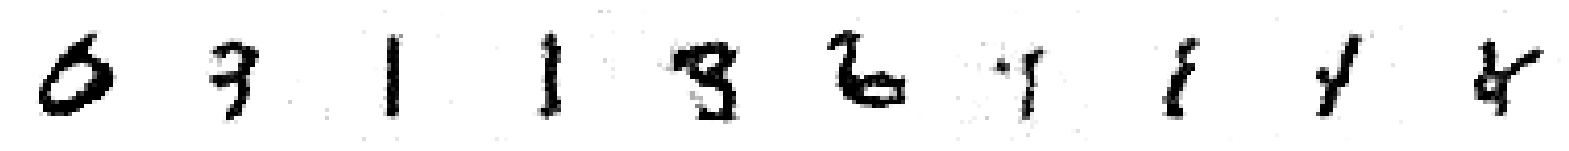

469/469 [==============================] - 354s 754ms/step - loss: -2.6035e-05 - reg: 2.7408e-04 - cdiv: -3.0011e-04 - real: 7.0095e-04 - fake: 4.0084e-04 - val_cdiv: -13.5025 - val_real: -0.0122 - val_fake: -13.5147
Epoch 24/60
469/469 [==============================] - ETA: 0s - loss: -1.9273e-04 - reg: 2.6298e-04 - cdiv: -4.5570e-04 - real: 0.0011 - fake: 6.8628e-04
Saved to ./temp/output/generated_img_023.png


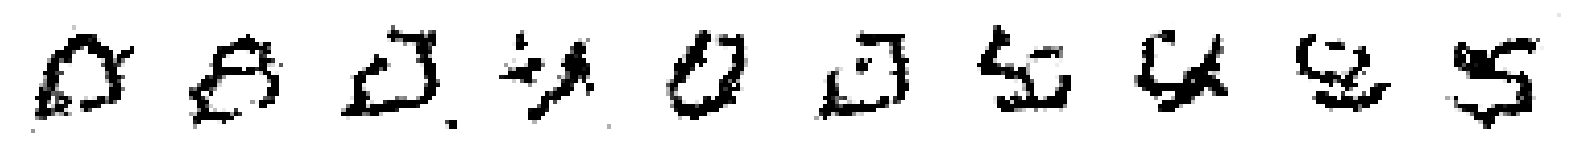


Saved to ./temp/output/example_img_023.png


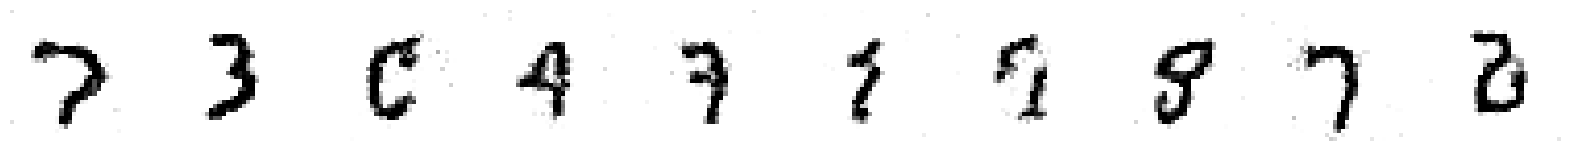

469/469 [==============================] - 347s 739ms/step - loss: -1.9273e-04 - reg: 2.6298e-04 - cdiv: -4.5570e-04 - real: 0.0011 - fake: 6.8628e-04 - val_cdiv: -14.2096 - val_real: -0.0025 - val_fake: -14.2121
Epoch 25/60
469/469 [==============================] - ETA: 0s - loss: 2.2499e-04 - reg: 2.9583e-04 - cdiv: -7.0835e-05 - real: 9.7914e-04 - fake: 9.0830e-04
Saved to ./temp/output/generated_img_024.png


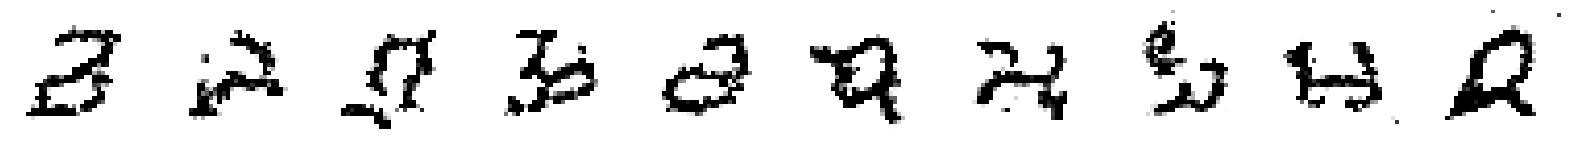


Saved to ./temp/output/example_img_024.png


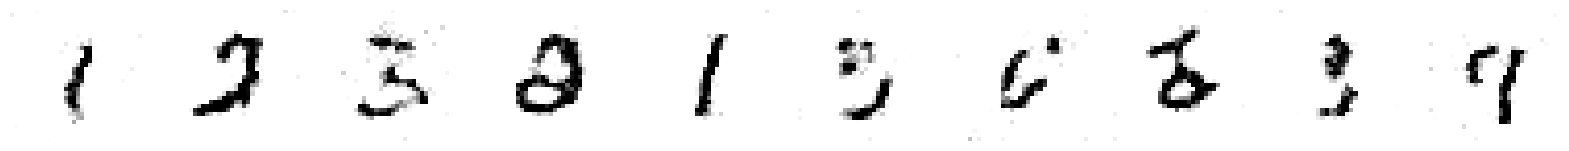

469/469 [==============================] - 351s 749ms/step - loss: 2.2499e-04 - reg: 2.9583e-04 - cdiv: -7.0835e-05 - real: 9.7914e-04 - fake: 9.0830e-04 - val_cdiv: -14.8374 - val_real: 8.3079e-04 - val_fake: -14.8366
Epoch 26/60
469/469 [==============================] - ETA: 0s - loss: -5.7521e-05 - reg: 3.0830e-04 - cdiv: -3.6582e-04 - real: 0.0011 - fake: 7.6845e-04
Saved to ./temp/output/generated_img_025.png


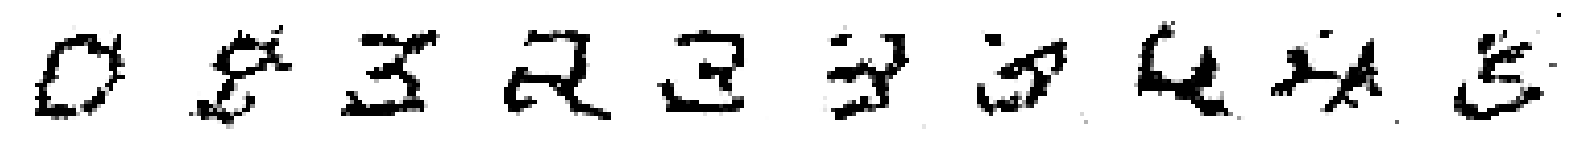


Saved to ./temp/output/example_img_025.png


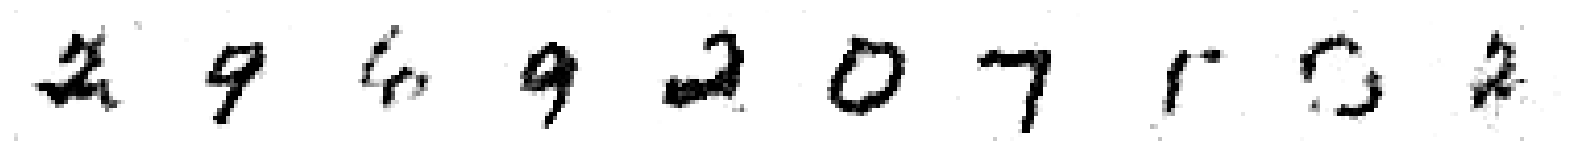

469/469 [==============================] - 357s 762ms/step - loss: -5.7521e-05 - reg: 3.0830e-04 - cdiv: -3.6582e-04 - real: 0.0011 - fake: 7.6845e-04 - val_cdiv: -15.5391 - val_real: -0.0083 - val_fake: -15.5474
Epoch 27/60
469/469 [==============================] - ETA: 0s - loss: 4.4017e-04 - reg: 2.1589e-04 - cdiv: 2.2428e-04 - real: 7.6230e-04 - fake: 9.8658e-04
Saved to ./temp/output/generated_img_026.png


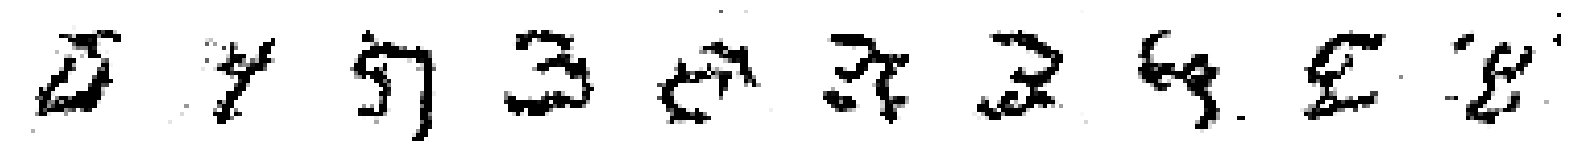


Saved to ./temp/output/example_img_026.png


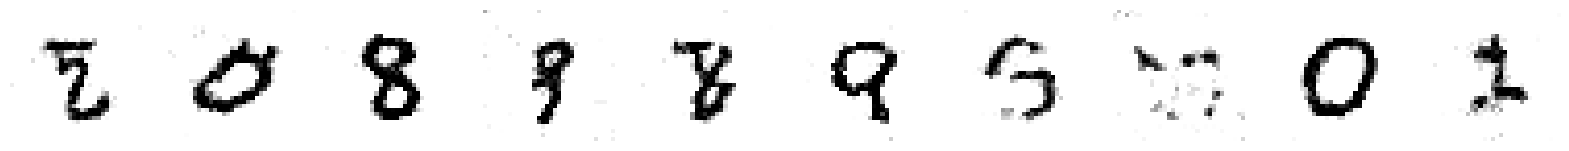

469/469 [==============================] - 359s 765ms/step - loss: 4.4017e-04 - reg: 2.1589e-04 - cdiv: 2.2428e-04 - real: 7.6230e-04 - fake: 9.8658e-04 - val_cdiv: -15.6614 - val_real: -0.0095 - val_fake: -15.6709
Epoch 28/60
469/469 [==============================] - ETA: 0s - loss: 2.7989e-06 - reg: 2.6336e-04 - cdiv: -2.6056e-04 - real: 8.7545e-04 - fake: 6.1489e-04 
Saved to ./temp/output/generated_img_027.png


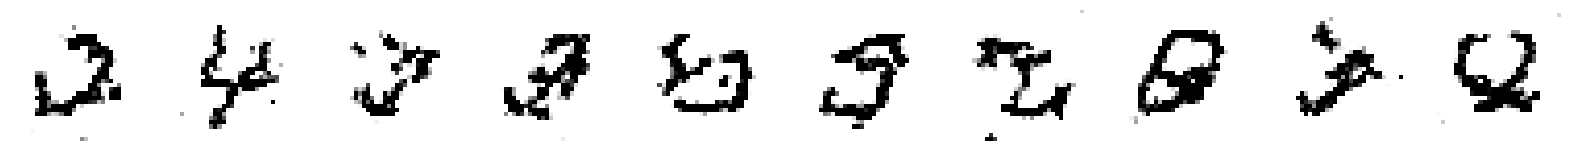


Saved to ./temp/output/example_img_027.png


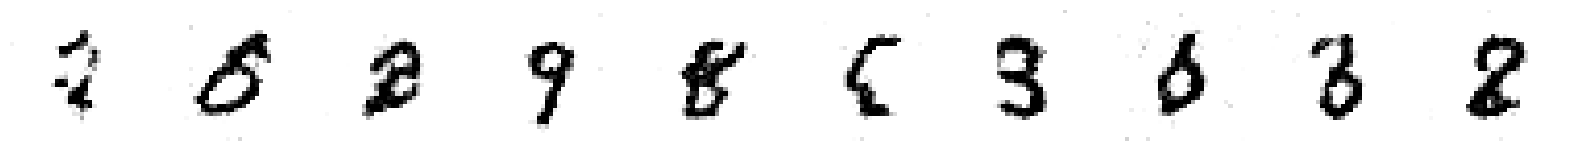

469/469 [==============================] - 371s 792ms/step - loss: 2.7989e-06 - reg: 2.6336e-04 - cdiv: -2.6056e-04 - real: 8.7545e-04 - fake: 6.1489e-04 - val_cdiv: -16.2904 - val_real: -0.0096 - val_fake: -16.3000
Epoch 29/60
469/469 [==============================] - ETA: 0s - loss: 2.0198e-04 - reg: 2.2907e-04 - cdiv: -2.7096e-05 - real: 5.6445e-04 - fake: 5.3735e-04
Saved to ./temp/output/generated_img_028.png


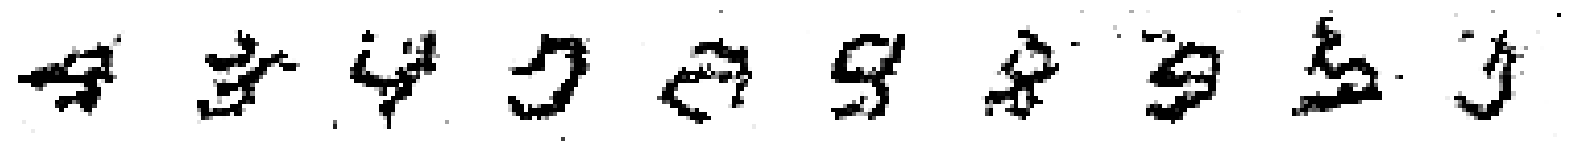


Saved to ./temp/output/example_img_028.png


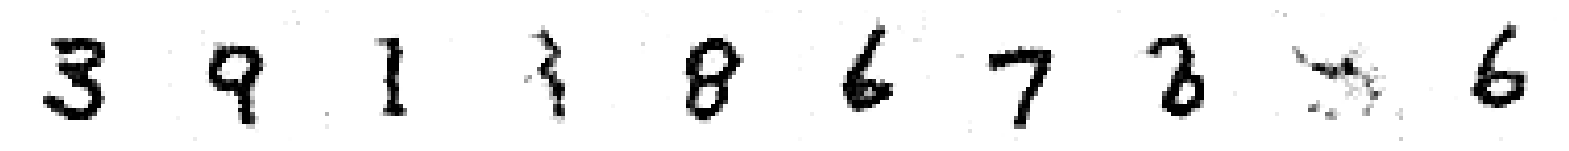

469/469 [==============================] - 366s 780ms/step - loss: 2.0198e-04 - reg: 2.2907e-04 - cdiv: -2.7096e-05 - real: 5.6445e-04 - fake: 5.3735e-04 - val_cdiv: -16.6328 - val_real: -0.0039 - val_fake: -16.6368
Epoch 30/60
469/469 [==============================] - ETA: 0s - loss: -1.2087e-05 - reg: 1.8848e-04 - cdiv: -2.0057e-04 - real: 6.3666e-04 - fake: 4.3609e-04
Saved to ./temp/output/generated_img_029.png


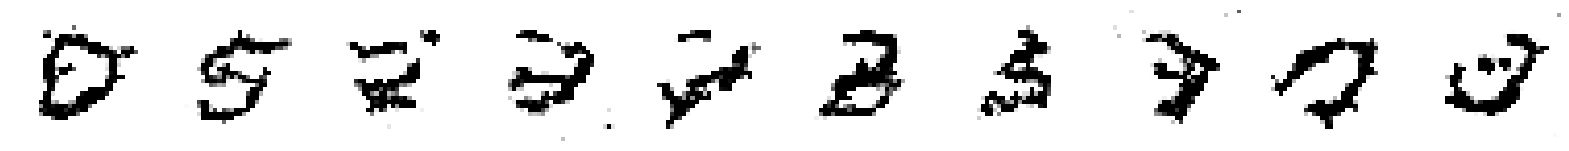


Saved to ./temp/output/example_img_029.png


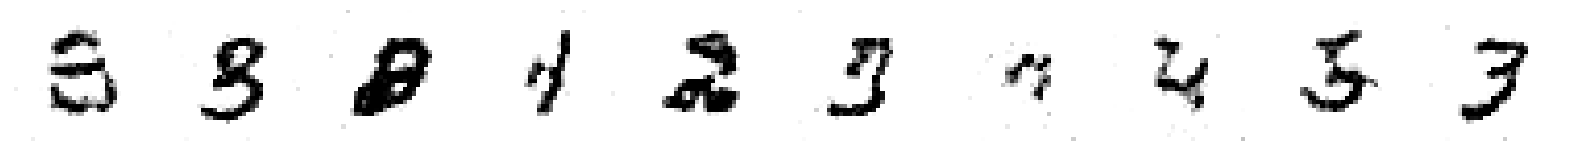

469/469 [==============================] - 377s 803ms/step - loss: -1.2087e-05 - reg: 1.8848e-04 - cdiv: -2.0057e-04 - real: 6.3666e-04 - fake: 4.3609e-04 - val_cdiv: -17.5101 - val_real: -0.0044 - val_fake: -17.5145
Epoch 31/60
469/469 [==============================] - ETA: 0s - loss: 1.6848e-04 - reg: 2.1295e-04 - cdiv: -4.4474e-05 - real: 0.0010 - fake: 9.7719e-04  
Saved to ./temp/output/generated_img_030.png


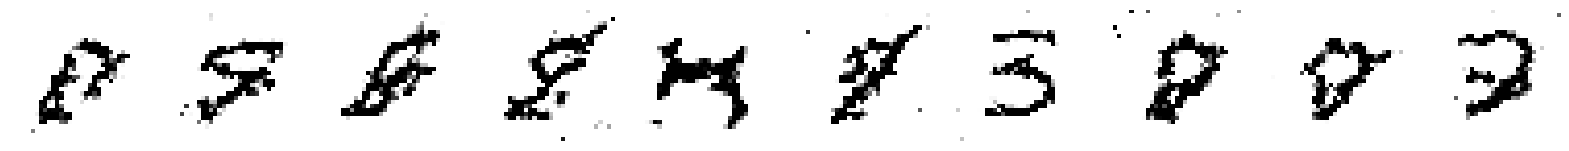


Saved to ./temp/output/example_img_030.png


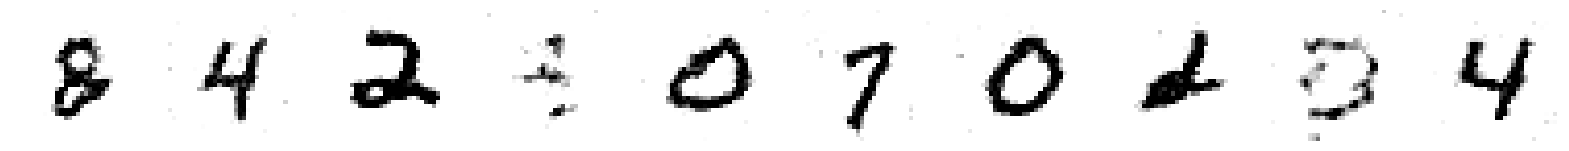

469/469 [==============================] - 380s 811ms/step - loss: 1.6848e-04 - reg: 2.1295e-04 - cdiv: -4.4474e-05 - real: 0.0010 - fake: 9.7719e-04 - val_cdiv: -18.0125 - val_real: -0.0042 - val_fake: -18.0166
Epoch 32/60
469/469 [==============================] - ETA: 0s - loss: 1.1954e-04 - reg: 2.2103e-04 - cdiv: -1.0149e-04 - real: 2.3644e-04 - fake: 1.3495e-04
Saved to ./temp/output/generated_img_031.png


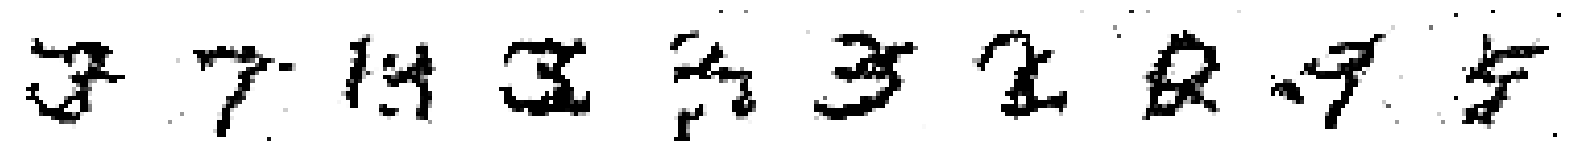


Saved to ./temp/output/example_img_031.png


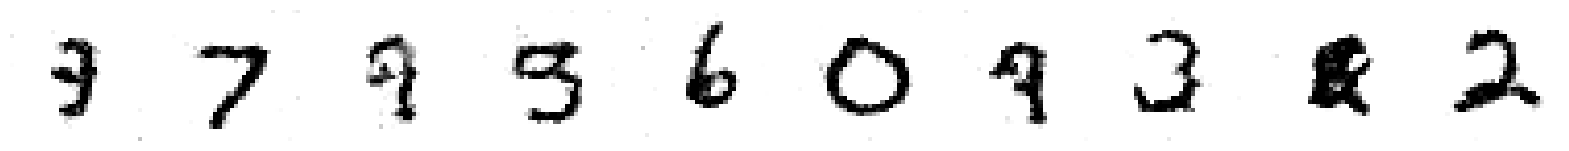

469/469 [==============================] - 386s 823ms/step - loss: 1.1954e-04 - reg: 2.2103e-04 - cdiv: -1.0149e-04 - real: 2.3644e-04 - fake: 1.3495e-04 - val_cdiv: -18.5373 - val_real: 6.4785e-04 - val_fake: -18.5366
Epoch 33/60
469/469 [==============================] - ETA: 0s - loss: 1.5440e-04 - reg: 2.3031e-04 - cdiv: -7.5913e-05 - real: 3.9614e-04 - fake: 3.2023e-04
Saved to ./temp/output/generated_img_032.png


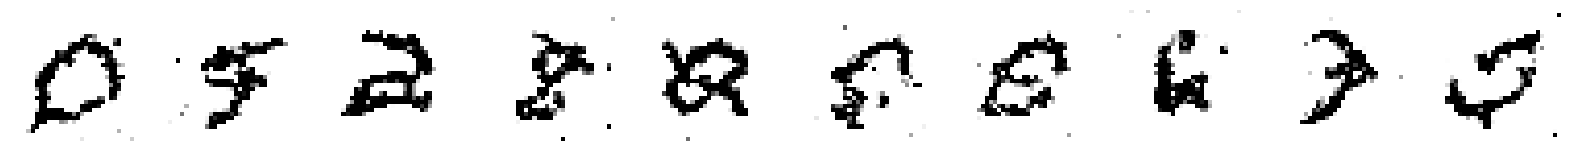


Saved to ./temp/output/example_img_032.png


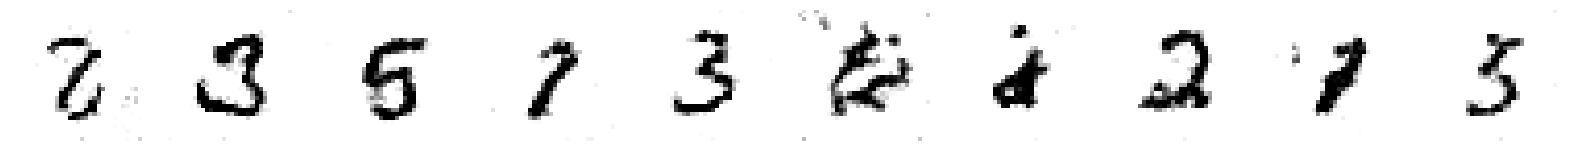

469/469 [==============================] - 370s 789ms/step - loss: 1.5440e-04 - reg: 2.3031e-04 - cdiv: -7.5913e-05 - real: 3.9614e-04 - fake: 3.2023e-04 - val_cdiv: -19.0127 - val_real: -0.0016 - val_fake: -19.0143
Epoch 34/60
469/469 [==============================] - ETA: 0s - loss: 1.0689e-04 - reg: 2.1578e-04 - cdiv: -1.0890e-04 - real: 7.9140e-04 - fake: 6.8251e-04
Saved to ./temp/output/generated_img_033.png


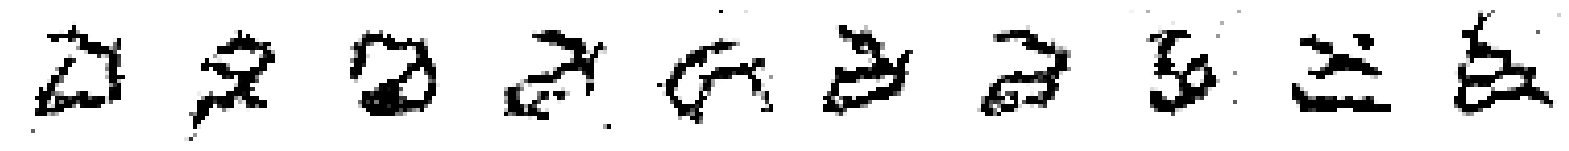


Saved to ./temp/output/example_img_033.png


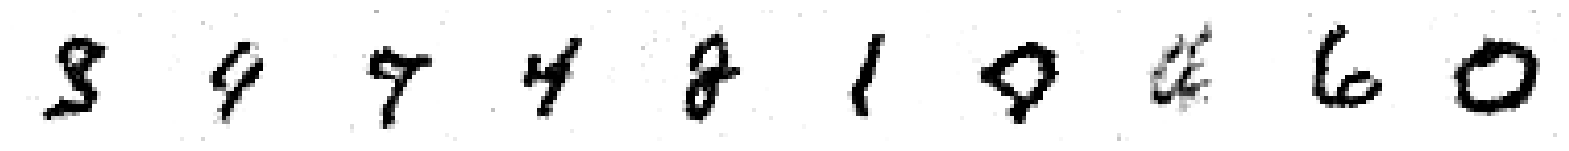

469/469 [==============================] - 377s 803ms/step - loss: 1.0689e-04 - reg: 2.1578e-04 - cdiv: -1.0890e-04 - real: 7.9140e-04 - fake: 6.8251e-04 - val_cdiv: -19.5866 - val_real: -0.0097 - val_fake: -19.5963
Epoch 35/60
469/469 [==============================] - ETA: 0s - loss: 3.9325e-04 - reg: 2.0748e-04 - cdiv: 1.8576e-04 - real: 7.0227e-04 - fake: 8.8804e-04
Saved to ./temp/output/generated_img_034.png


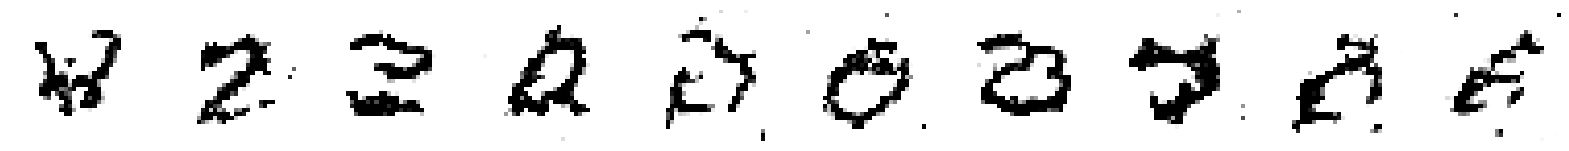


Saved to ./temp/output/example_img_034.png


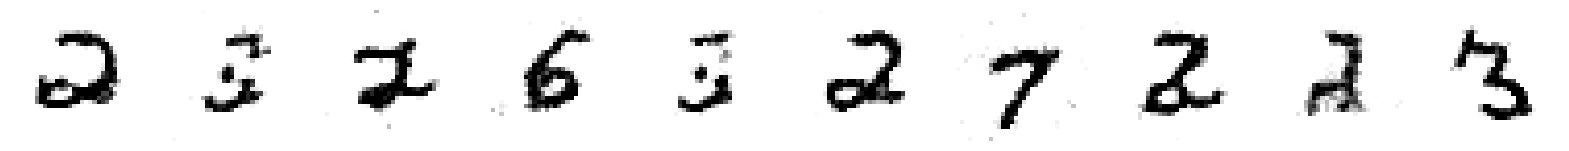

469/469 [==============================] - 359s 765ms/step - loss: 3.9325e-04 - reg: 2.0748e-04 - cdiv: 1.8576e-04 - real: 7.0227e-04 - fake: 8.8804e-04 - val_cdiv: -19.7518 - val_real: -0.0133 - val_fake: -19.7651
Epoch 36/60
469/469 [==============================] - ETA: 0s - loss: -3.5601e-05 - reg: 2.4511e-04 - cdiv: -2.8072e-04 - real: 5.5076e-04 - fake: 2.7005e-04
Saved to ./temp/output/generated_img_035.png


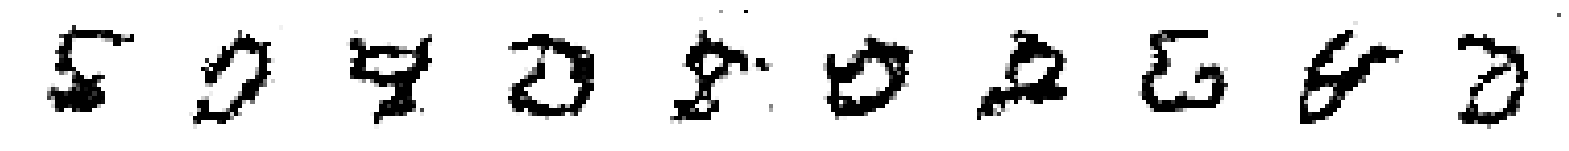


Saved to ./temp/output/example_img_035.png


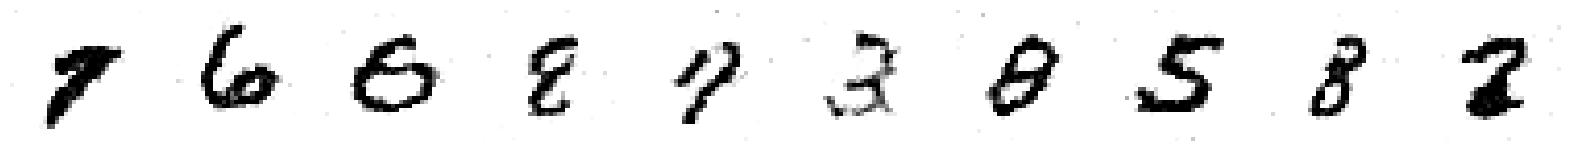

469/469 [==============================] - 349s 745ms/step - loss: -3.5601e-05 - reg: 2.4511e-04 - cdiv: -2.8072e-04 - real: 5.5076e-04 - fake: 2.7005e-04 - val_cdiv: -20.5838 - val_real: -0.0241 - val_fake: -20.6080
Epoch 37/60
469/469 [==============================] - ETA: 0s - loss: 2.9654e-04 - reg: 2.5193e-04 - cdiv: 4.4610e-05 - real: 3.2535e-04 - fake: 3.6996e-04
Saved to ./temp/output/generated_img_036.png


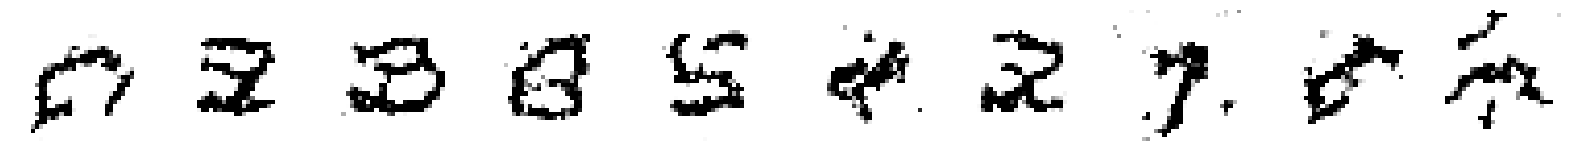


Saved to ./temp/output/example_img_036.png


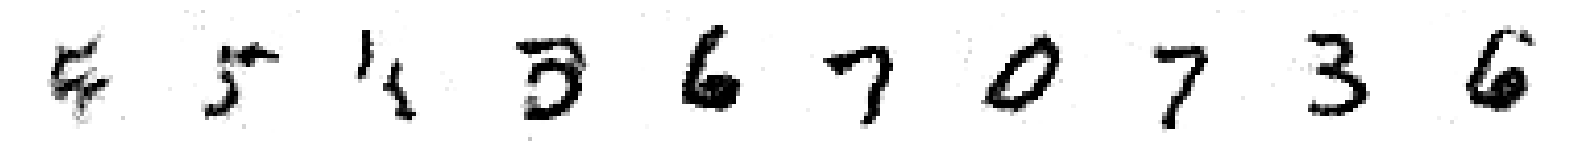

469/469 [==============================] - 349s 743ms/step - loss: 2.9654e-04 - reg: 2.5193e-04 - cdiv: 4.4610e-05 - real: 3.2535e-04 - fake: 3.6996e-04 - val_cdiv: -20.9200 - val_real: -0.0168 - val_fake: -20.9368
Epoch 38/60
469/469 [==============================] - ETA: 0s - loss: 1.8997e-04 - reg: 2.0272e-04 - cdiv: -1.2748e-05 - real: 7.4262e-04 - fake: 7.2987e-04
Saved to ./temp/output/generated_img_037.png


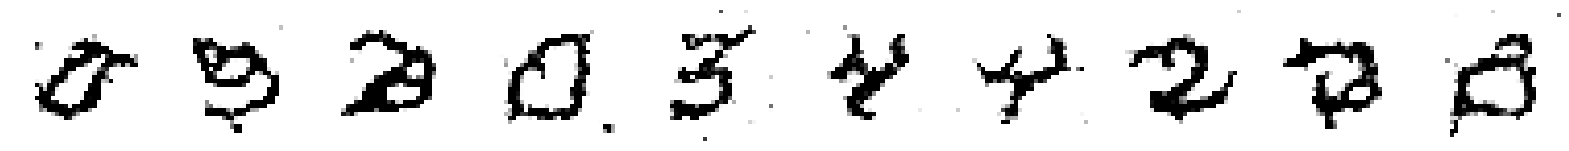


Saved to ./temp/output/example_img_037.png


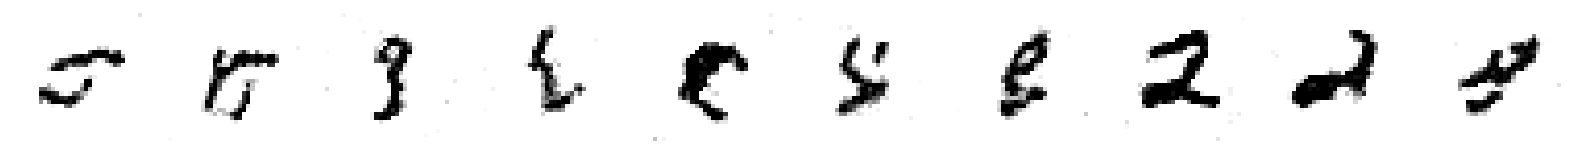

469/469 [==============================] - 351s 748ms/step - loss: 1.8997e-04 - reg: 2.0272e-04 - cdiv: -1.2748e-05 - real: 7.4262e-04 - fake: 7.2987e-04 - val_cdiv: -21.1997 - val_real: -0.0295 - val_fake: -21.2292
Epoch 39/60
469/469 [==============================] - ETA: 0s - loss: 6.9015e-05 - reg: 1.9787e-04 - cdiv: -1.2885e-04 - real: 9.0362e-04 - fake: 7.7477e-04
Saved to ./temp/output/generated_img_038.png


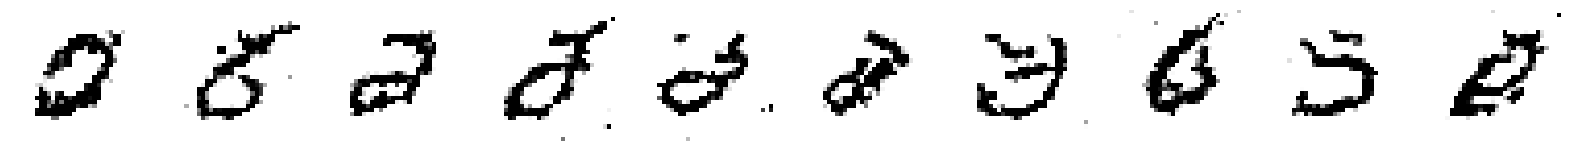


Saved to ./temp/output/example_img_038.png


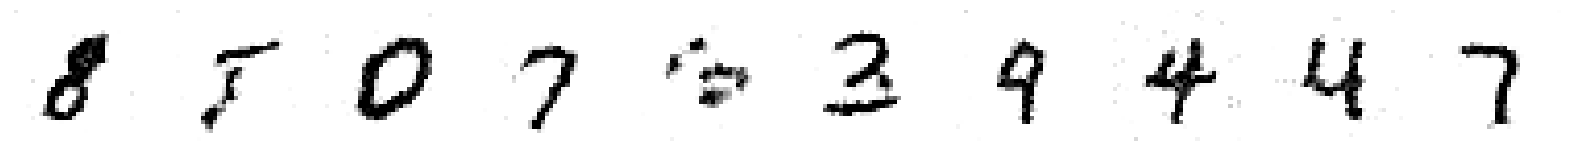

469/469 [==============================] - 350s 746ms/step - loss: 6.9015e-05 - reg: 1.9787e-04 - cdiv: -1.2885e-04 - real: 9.0362e-04 - fake: 7.7477e-04 - val_cdiv: -21.7887 - val_real: -0.0366 - val_fake: -21.8252
Epoch 40/60
469/469 [==============================] - ETA: 0s - loss: 2.1036e-04 - reg: 2.2897e-04 - cdiv: -1.8613e-05 - real: -2.1409e-04 - fake: -2.3270e-04
Saved to ./temp/output/generated_img_039.png


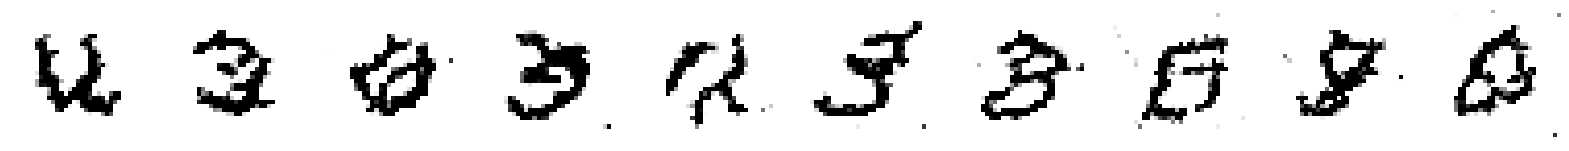


Saved to ./temp/output/example_img_039.png


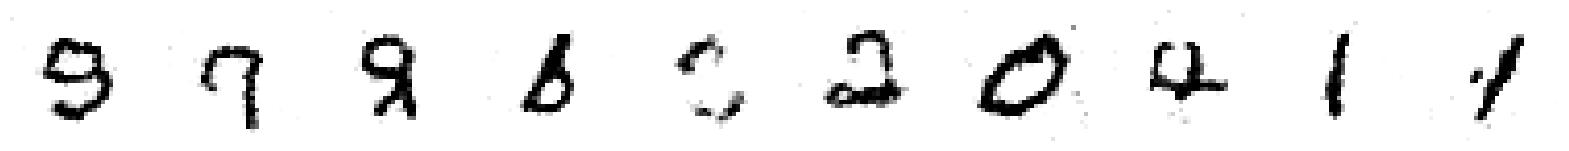

469/469 [==============================] - 343s 732ms/step - loss: 2.1036e-04 - reg: 2.2897e-04 - cdiv: -1.8613e-05 - real: -2.1409e-04 - fake: -2.3270e-04 - val_cdiv: -21.7060 - val_real: -0.0258 - val_fake: -21.7318
Epoch 41/60
469/469 [==============================] - ETA: 0s - loss: 1.9027e-04 - reg: 2.0804e-04 - cdiv: -1.7767e-05 - real: 9.2371e-04 - fake: 9.0595e-04
Saved to ./temp/output/generated_img_040.png


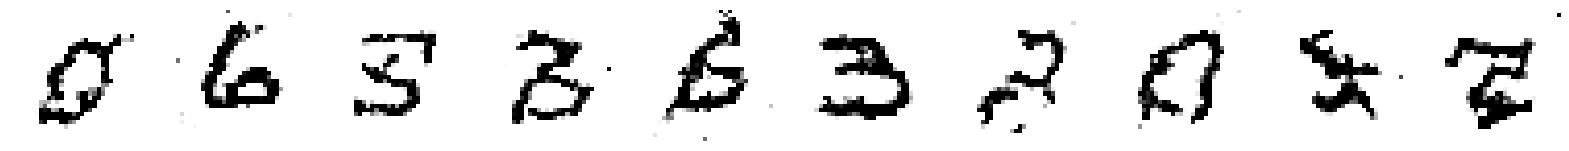


Saved to ./temp/output/example_img_040.png


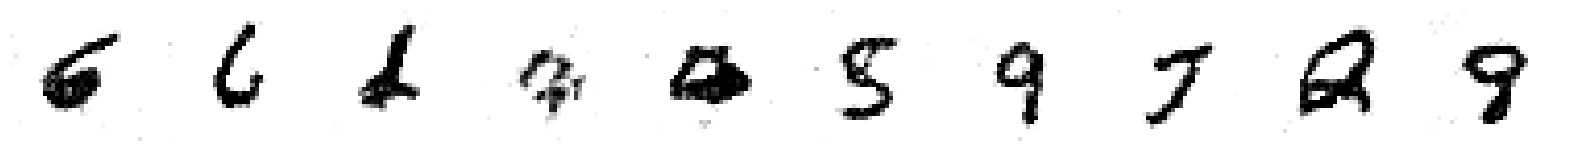

469/469 [==============================] - 341s 726ms/step - loss: 1.9027e-04 - reg: 2.0804e-04 - cdiv: -1.7767e-05 - real: 9.2371e-04 - fake: 9.0595e-04 - val_cdiv: -22.1346 - val_real: -0.0374 - val_fake: -22.1720
Epoch 42/60
469/469 [==============================] - ETA: 0s - loss: 1.3000e-04 - reg: 2.3883e-04 - cdiv: -1.0883e-04 - real: 4.0127e-04 - fake: 2.9244e-04
Saved to ./temp/output/generated_img_041.png


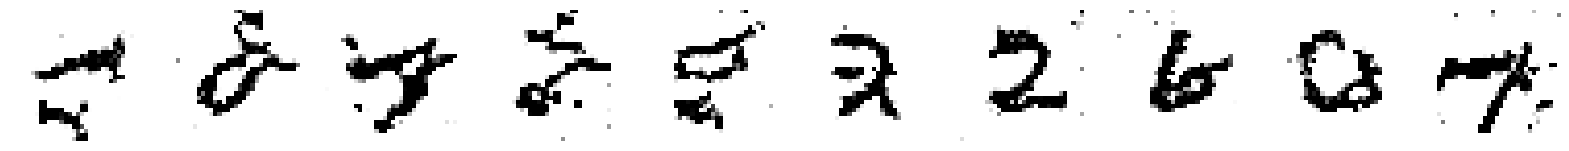


Saved to ./temp/output/example_img_041.png


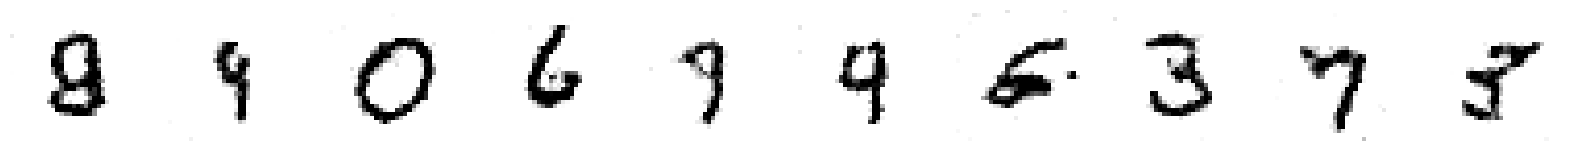

469/469 [==============================] - 341s 726ms/step - loss: 1.3000e-04 - reg: 2.3883e-04 - cdiv: -1.0883e-04 - real: 4.0127e-04 - fake: 2.9244e-04 - val_cdiv: -22.6100 - val_real: -0.0245 - val_fake: -22.6345
Epoch 43/60
469/469 [==============================] - ETA: 0s - loss: 7.5467e-05 - reg: 2.2717e-04 - cdiv: -1.5170e-04 - real: 3.0700e-04 - fake: 1.5530e-04
Saved to ./temp/output/generated_img_042.png


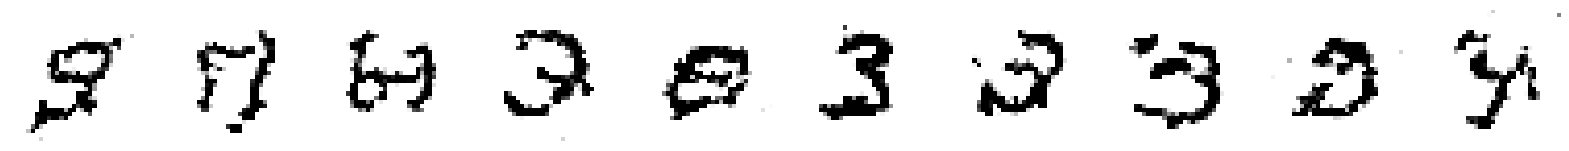


Saved to ./temp/output/example_img_042.png


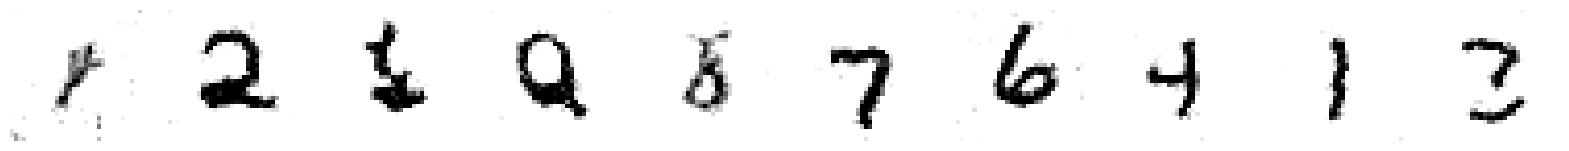

469/469 [==============================] - 345s 735ms/step - loss: 7.5467e-05 - reg: 2.2717e-04 - cdiv: -1.5170e-04 - real: 3.0700e-04 - fake: 1.5530e-04 - val_cdiv: -22.9921 - val_real: -0.0335 - val_fake: -23.0255
Epoch 44/60
469/469 [==============================] - ETA: 0s - loss: 1.2467e-04 - reg: 2.7354e-04 - cdiv: -1.4887e-04 - real: 7.2806e-04 - fake: 5.7919e-04
Saved to ./temp/output/generated_img_043.png


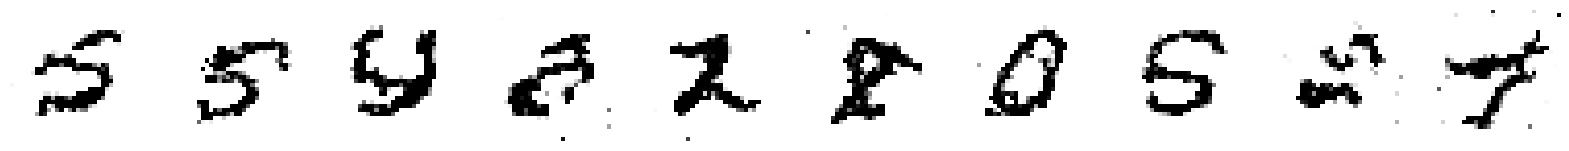


Saved to ./temp/output/example_img_043.png


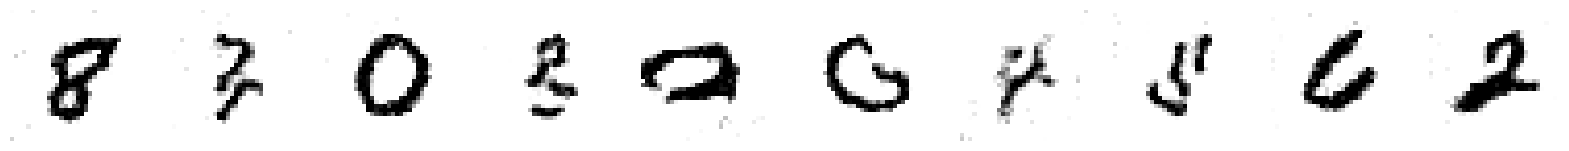

469/469 [==============================] - 354s 754ms/step - loss: 1.2467e-04 - reg: 2.7354e-04 - cdiv: -1.4887e-04 - real: 7.2806e-04 - fake: 5.7919e-04 - val_cdiv: -23.6348 - val_real: -0.0343 - val_fake: -23.6691
Epoch 45/60
469/469 [==============================] - ETA: 0s - loss: 2.6788e-04 - reg: 2.4883e-04 - cdiv: 1.9055e-05 - real: -6.2641e-05 - fake: -4.3587e-05
Saved to ./temp/output/generated_img_044.png


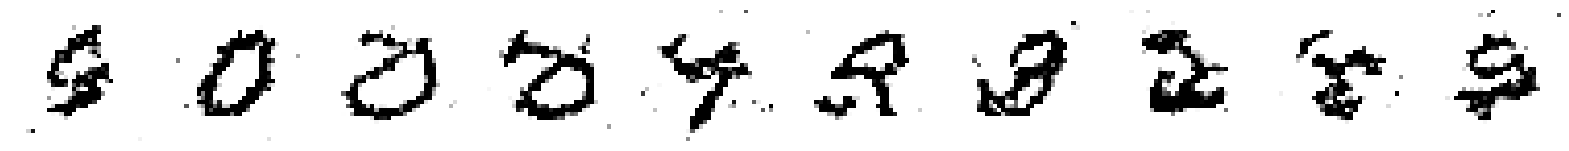


Saved to ./temp/output/example_img_044.png


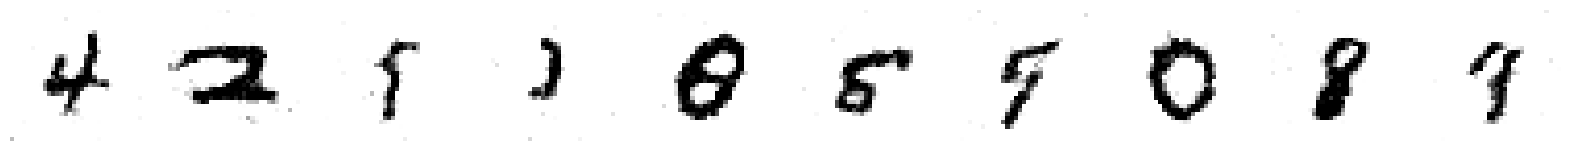

469/469 [==============================] - 342s 730ms/step - loss: 2.6788e-04 - reg: 2.4883e-04 - cdiv: 1.9055e-05 - real: -6.2641e-05 - fake: -4.3587e-05 - val_cdiv: -23.5258 - val_real: -0.0041 - val_fake: -23.5299
Epoch 46/60
469/469 [==============================] - ETA: 0s - loss: 1.7741e-04 - reg: 2.2417e-04 - cdiv: -4.6766e-05 - real: 6.3073e-04 - fake: 5.8396e-04
Saved to ./temp/output/generated_img_045.png


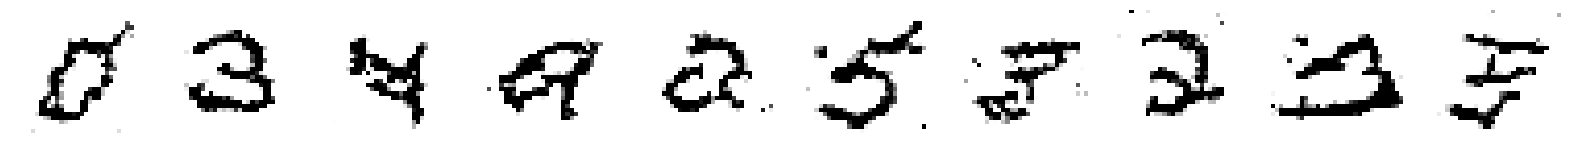


Saved to ./temp/output/example_img_045.png


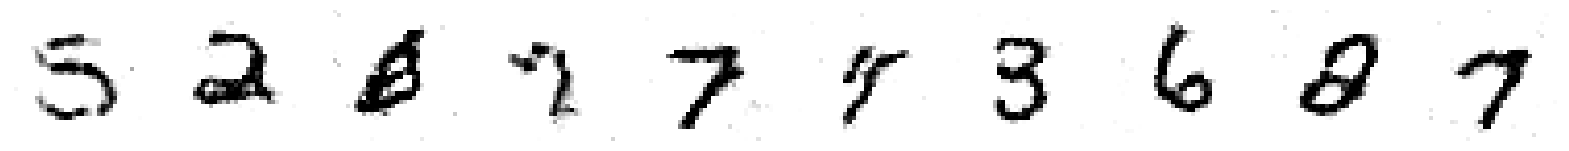

469/469 [==============================] - 341s 727ms/step - loss: 1.7741e-04 - reg: 2.2417e-04 - cdiv: -4.6766e-05 - real: 6.3073e-04 - fake: 5.8396e-04 - val_cdiv: -24.4301 - val_real: -0.0164 - val_fake: -24.4465
Epoch 47/60
469/469 [==============================] - ETA: 0s - loss: 4.3347e-05 - reg: 3.1715e-04 - cdiv: -2.7380e-04 - real: 5.5626e-04 - fake: 2.8246e-04
Saved to ./temp/output/generated_img_046.png


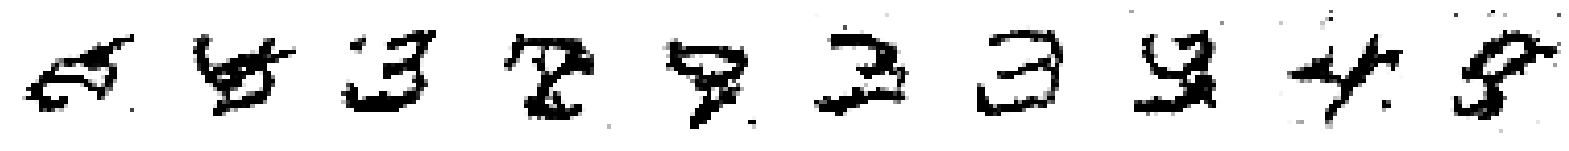


Saved to ./temp/output/example_img_046.png


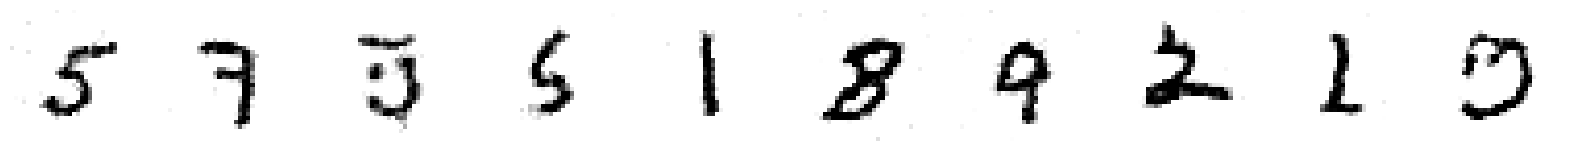

469/469 [==============================] - 352s 751ms/step - loss: 4.3347e-05 - reg: 3.1715e-04 - cdiv: -2.7380e-04 - real: 5.5626e-04 - fake: 2.8246e-04 - val_cdiv: -24.7285 - val_real: -0.0494 - val_fake: -24.7780
Epoch 48/60
469/469 [==============================] - ETA: 0s - loss: 3.6529e-04 - reg: 2.0263e-04 - cdiv: 1.6266e-04 - real: 5.3166e-04 - fake: 6.9432e-04
Saved to ./temp/output/generated_img_047.png


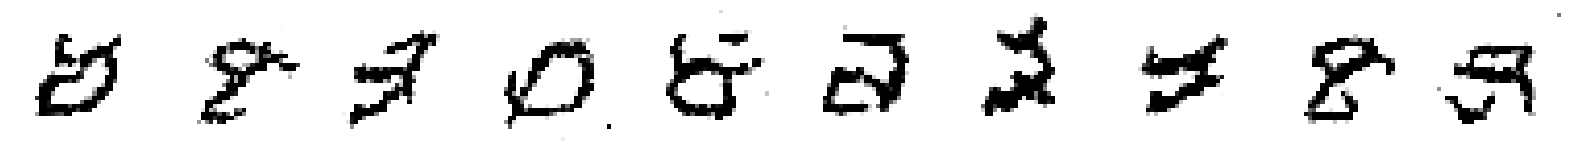


Saved to ./temp/output/example_img_047.png


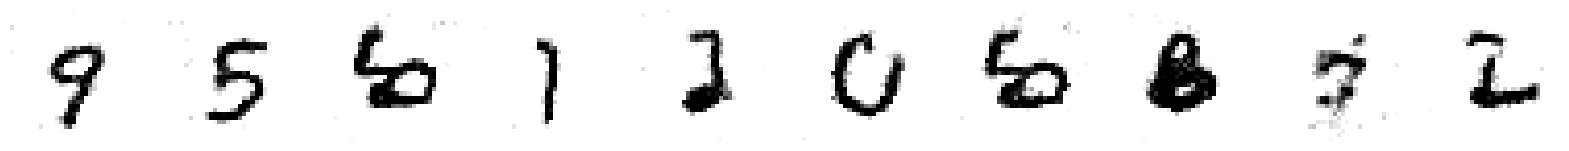

469/469 [==============================] - 349s 744ms/step - loss: 3.6529e-04 - reg: 2.0263e-04 - cdiv: 1.6266e-04 - real: 5.3166e-04 - fake: 6.9432e-04 - val_cdiv: -24.5171 - val_real: -0.0663 - val_fake: -24.5833
Epoch 49/60
469/469 [==============================] - ETA: 0s - loss: -6.8429e-06 - reg: 2.5683e-04 - cdiv: -2.6367e-04 - real: -6.2797e-05 - fake: -3.2647e-04
Saved to ./temp/output/generated_img_048.png


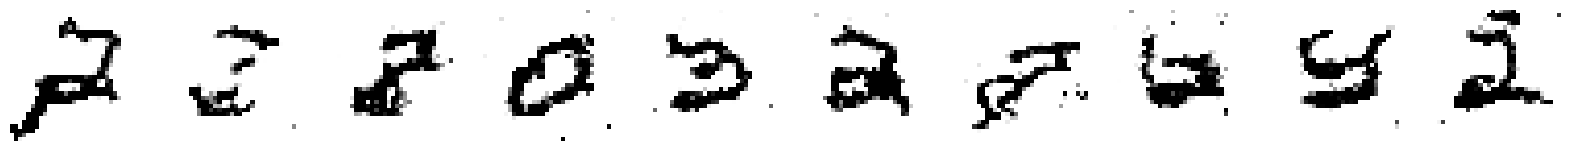


Saved to ./temp/output/example_img_048.png


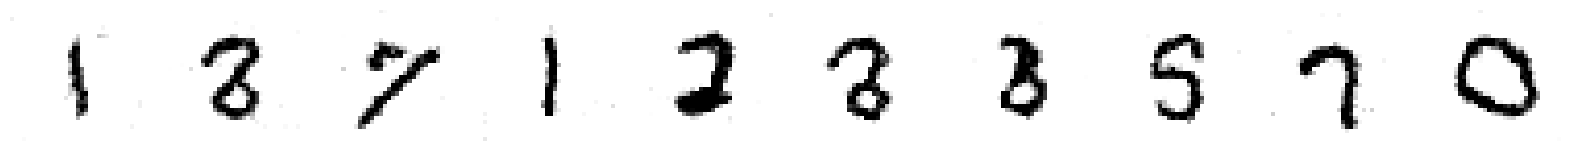

469/469 [==============================] - 346s 737ms/step - loss: -6.8429e-06 - reg: 2.5683e-04 - cdiv: -2.6367e-04 - real: -6.2797e-05 - fake: -3.2647e-04 - val_cdiv: -25.5273 - val_real: -0.0297 - val_fake: -25.5570
Epoch 50/60
469/469 [==============================] - ETA: 0s - loss: 7.6924e-05 - reg: 2.4627e-04 - cdiv: -1.6935e-04 - real: 5.9099e-04 - fake: 4.2164e-04
Saved to ./temp/output/generated_img_049.png


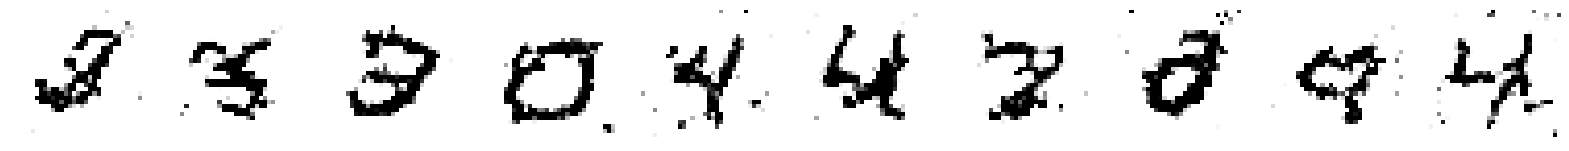


Saved to ./temp/output/example_img_049.png


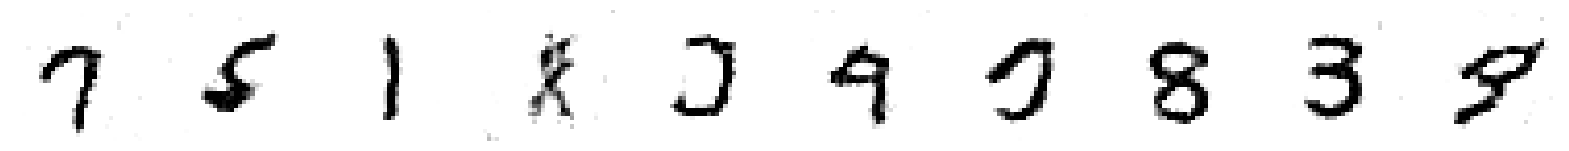

469/469 [==============================] - 349s 744ms/step - loss: 7.6924e-05 - reg: 2.4627e-04 - cdiv: -1.6935e-04 - real: 5.9099e-04 - fake: 4.2164e-04 - val_cdiv: -25.5487 - val_real: -0.0301 - val_fake: -25.5788
Epoch 51/60
469/469 [==============================] - ETA: 0s - loss: 2.6812e-04 - reg: 2.2572e-04 - cdiv: 4.2402e-05 - real: 4.7467e-04 - fake: 5.1707e-04
Saved to ./temp/output/generated_img_050.png


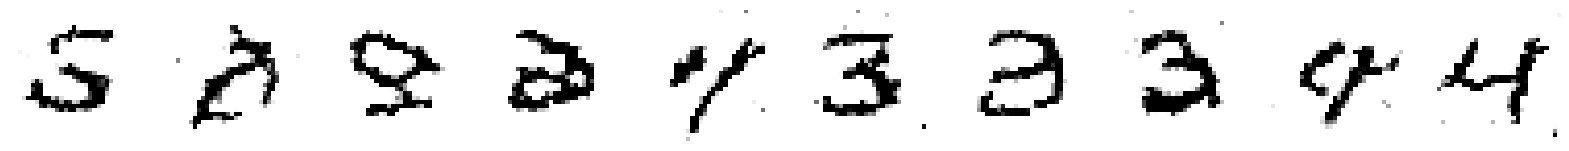


Saved to ./temp/output/example_img_050.png


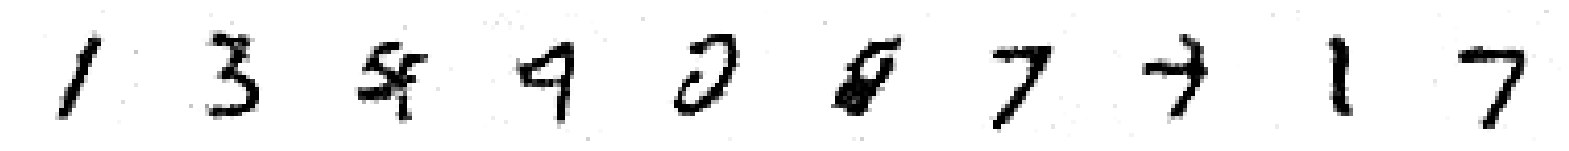

469/469 [==============================] - 348s 741ms/step - loss: 2.6812e-04 - reg: 2.2572e-04 - cdiv: 4.2402e-05 - real: 4.7467e-04 - fake: 5.1707e-04 - val_cdiv: -25.4727 - val_real: -0.0448 - val_fake: -25.5175
Epoch 52/60
469/469 [==============================] - ETA: 0s - loss: 1.8924e-04 - reg: 1.7967e-04 - cdiv: 9.5636e-06 - real: 7.5257e-04 - fake: 7.6213e-04 
Saved to ./temp/output/generated_img_051.png


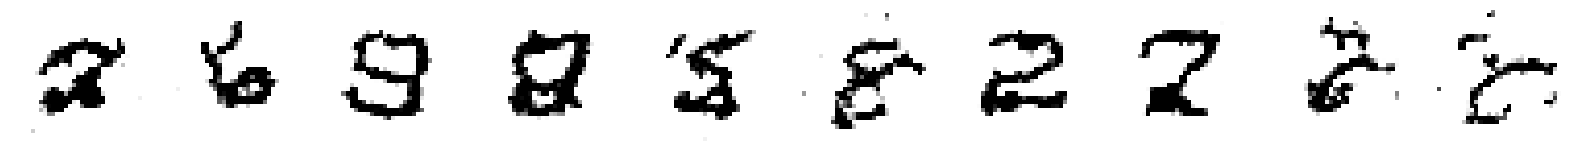


Saved to ./temp/output/example_img_051.png


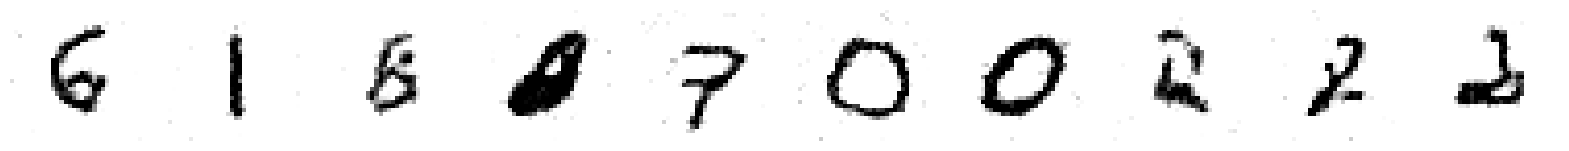

469/469 [==============================] - 342s 728ms/step - loss: 1.8924e-04 - reg: 1.7967e-04 - cdiv: 9.5636e-06 - real: 7.5257e-04 - fake: 7.6213e-04 - val_cdiv: -26.1809 - val_real: -0.0431 - val_fake: -26.2240
Epoch 53/60
469/469 [==============================] - ETA: 0s - loss: 2.3248e-04 - reg: 2.3185e-04 - cdiv: 6.3073e-07 - real: 3.7346e-04 - fake: 3.7409e-04
Saved to ./temp/output/generated_img_052.png


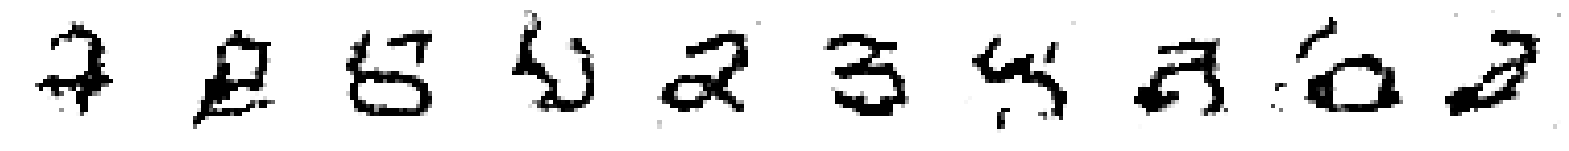


Saved to ./temp/output/example_img_052.png


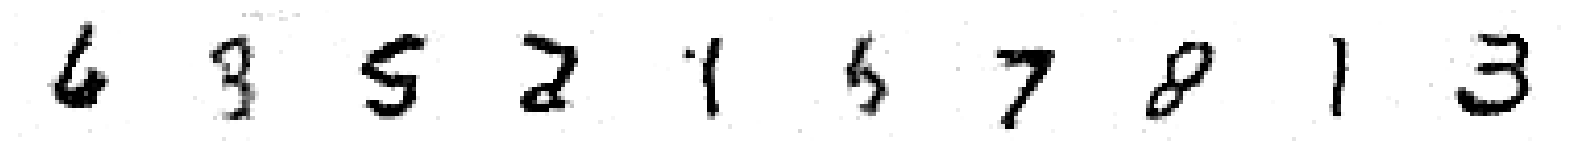

469/469 [==============================] - 342s 728ms/step - loss: 2.3248e-04 - reg: 2.3185e-04 - cdiv: 6.3073e-07 - real: 3.7346e-04 - fake: 3.7409e-04 - val_cdiv: -26.0948 - val_real: -0.0530 - val_fake: -26.1478
Epoch 54/60
469/469 [==============================] - ETA: 0s - loss: 2.3581e-04 - reg: 2.1333e-04 - cdiv: 2.2486e-05 - real: -1.7722e-04 - fake: -1.5474e-04
Saved to ./temp/output/generated_img_053.png


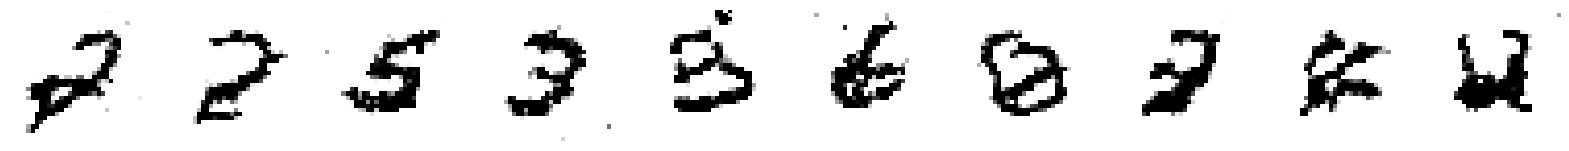


Saved to ./temp/output/example_img_053.png


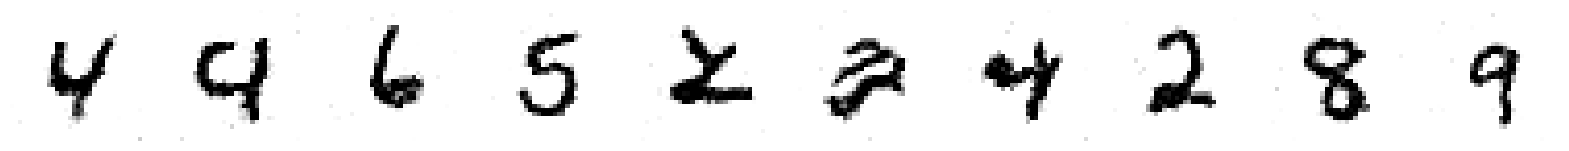

469/469 [==============================] - 341s 727ms/step - loss: 2.3581e-04 - reg: 2.1333e-04 - cdiv: 2.2486e-05 - real: -1.7722e-04 - fake: -1.5474e-04 - val_cdiv: -26.3897 - val_real: -0.0439 - val_fake: -26.4336
Epoch 55/60
469/469 [==============================] - ETA: 0s - loss: 1.8660e-04 - reg: 3.0921e-04 - cdiv: -1.2261e-04 - real: 7.1780e-04 - fake: 5.9520e-04
Saved to ./temp/output/generated_img_054.png


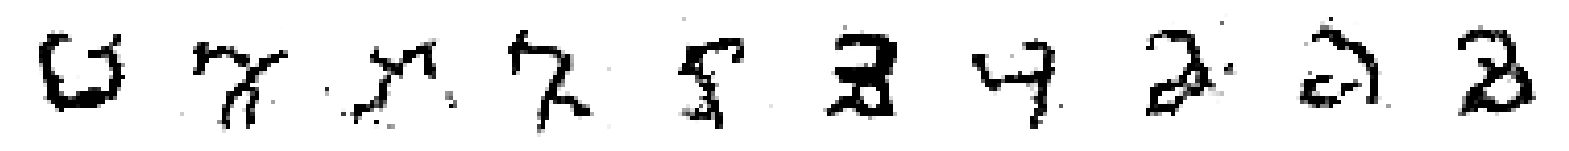


Saved to ./temp/output/example_img_054.png


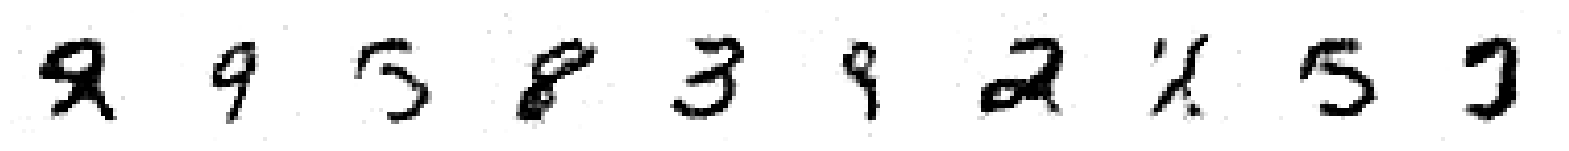

469/469 [==============================] - 340s 726ms/step - loss: 1.8660e-04 - reg: 3.0921e-04 - cdiv: -1.2261e-04 - real: 7.1780e-04 - fake: 5.9520e-04 - val_cdiv: -27.3093 - val_real: -0.0428 - val_fake: -27.3522
Epoch 56/60
469/469 [==============================] - ETA: 0s - loss: 1.4750e-04 - reg: 1.9343e-04 - cdiv: -4.5927e-05 - real: 3.2878e-04 - fake: 2.8286e-04
Saved to ./temp/output/generated_img_055.png


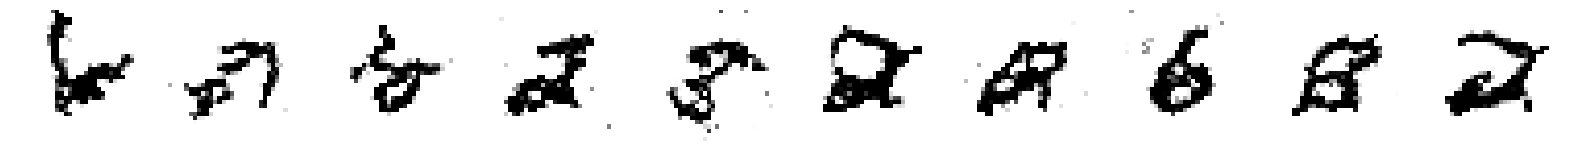


Saved to ./temp/output/example_img_055.png


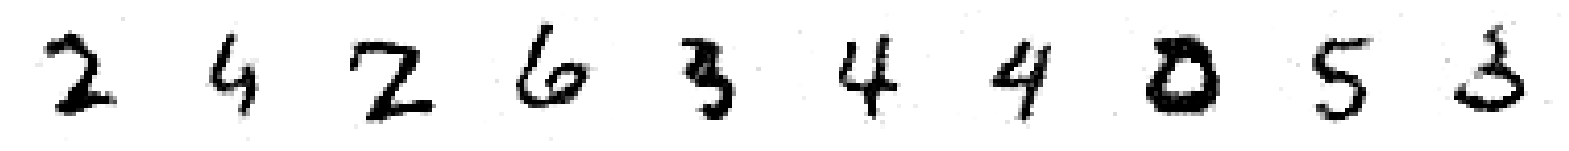

469/469 [==============================] - 341s 727ms/step - loss: 1.4750e-04 - reg: 1.9343e-04 - cdiv: -4.5927e-05 - real: 3.2878e-04 - fake: 2.8286e-04 - val_cdiv: -27.1747 - val_real: -0.0471 - val_fake: -27.2218
Epoch 57/60
469/469 [==============================] - ETA: 0s - loss: 1.6214e-05 - reg: 2.1803e-04 - cdiv: -2.0182e-04 - real: 1.1574e-04 - fake: -8.6083e-05
Saved to ./temp/output/generated_img_056.png


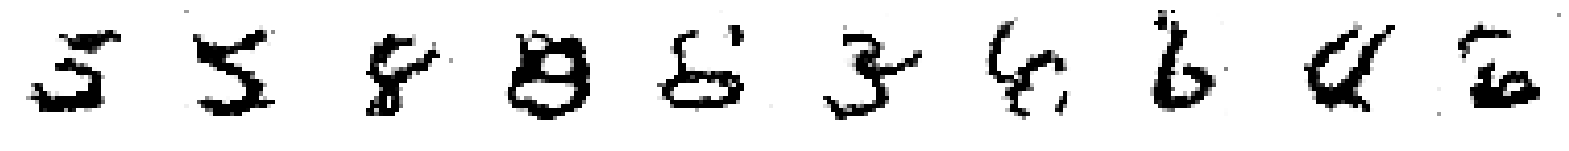


Saved to ./temp/output/example_img_056.png


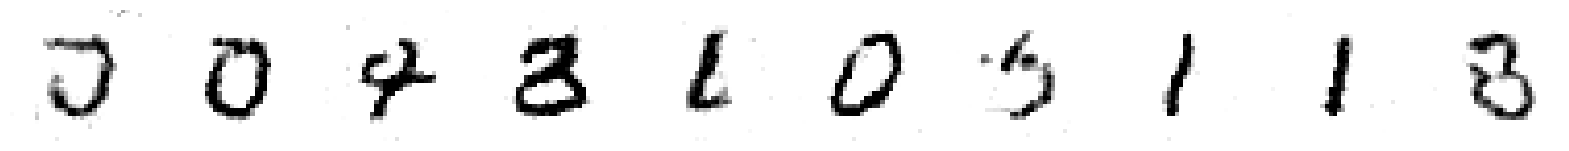

469/469 [==============================] - 342s 728ms/step - loss: 1.6214e-05 - reg: 2.1803e-04 - cdiv: -2.0182e-04 - real: 1.1574e-04 - fake: -8.6083e-05 - val_cdiv: -28.0567 - val_real: -0.0497 - val_fake: -28.1064
Epoch 58/60
469/469 [==============================] - ETA: 0s - loss: 8.0771e-05 - reg: 2.8782e-04 - cdiv: -2.0704e-04 - real: 9.4510e-04 - fake: 7.3805e-04
Saved to ./temp/output/generated_img_057.png


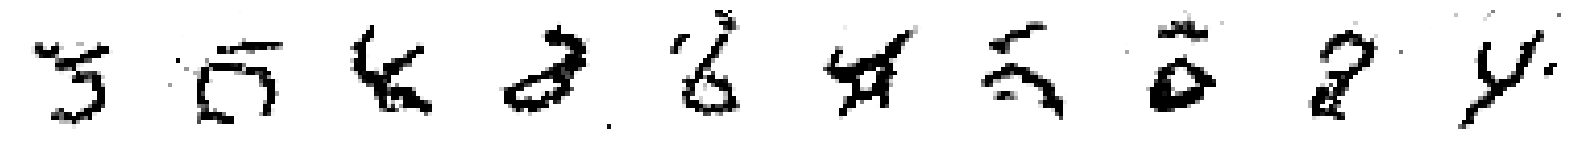


Saved to ./temp/output/example_img_057.png


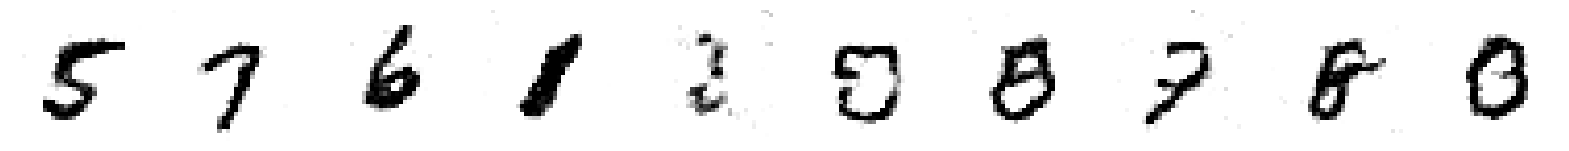

469/469 [==============================] - 342s 729ms/step - loss: 8.0771e-05 - reg: 2.8782e-04 - cdiv: -2.0704e-04 - real: 9.4510e-04 - fake: 7.3805e-04 - val_cdiv: -28.9968 - val_real: -0.0550 - val_fake: -29.0518
Epoch 59/60
469/469 [==============================] - ETA: 0s - loss: 4.7533e-04 - reg: 2.3033e-04 - cdiv: 2.4500e-04 - real: 7.8762e-04 - fake: 0.0010
Saved to ./temp/output/generated_img_058.png


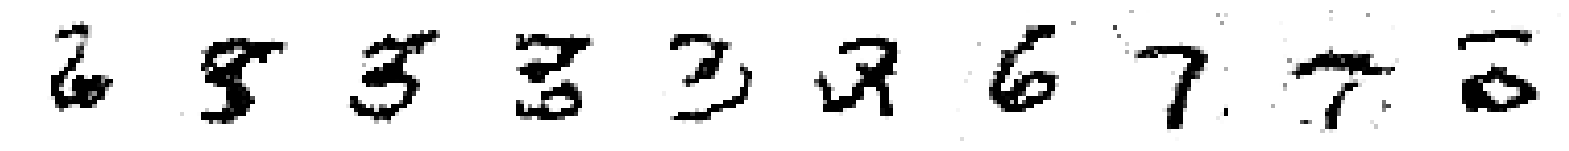


Saved to ./temp/output/example_img_058.png


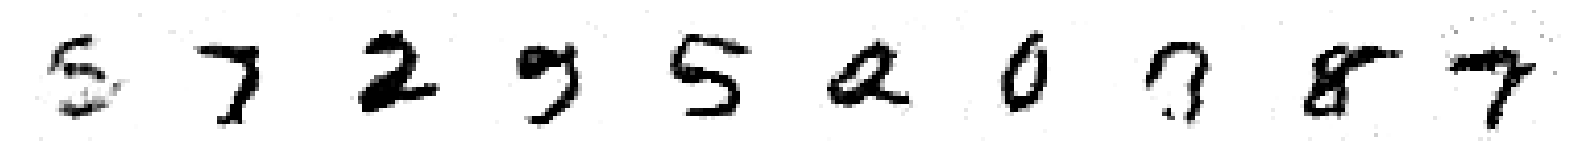

469/469 [==============================] - 342s 730ms/step - loss: 4.7533e-04 - reg: 2.3033e-04 - cdiv: 2.4500e-04 - real: 7.8762e-04 - fake: 0.0010 - val_cdiv: -27.6441 - val_real: -0.0788 - val_fake: -27.7229
Epoch 60/60
469/469 [==============================] - ETA: 0s - loss: 2.0265e-04 - reg: 2.7956e-04 - cdiv: -7.6913e-05 - real: -6.0590e-04 - fake: -6.8281e-04
Saved to ./temp/output/generated_img_059.png


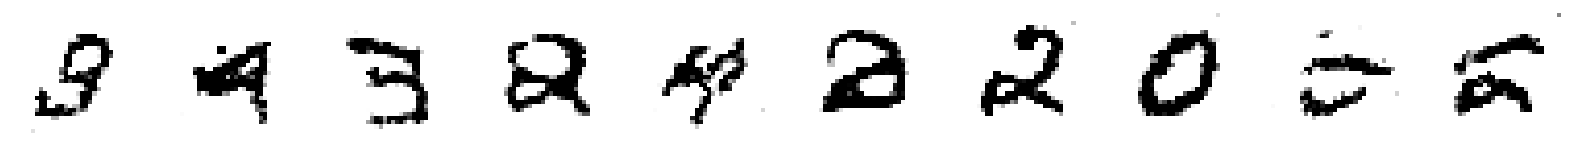


Saved to ./temp/output/example_img_059.png


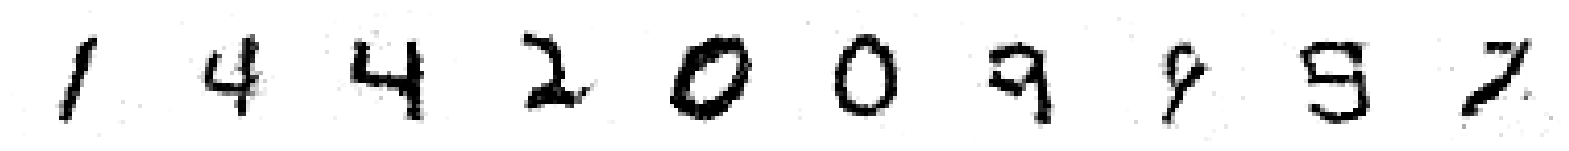

469/469 [==============================] - 340s 725ms/step - loss: 2.0265e-04 - reg: 2.7956e-04 - cdiv: -7.6913e-05 - real: -6.0590e-04 - fake: -6.8281e-04 - val_cdiv: -27.7748 - val_real: -0.0673 - val_fake: -27.8421


In [10]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

Path("./temp/output").mkdir(exist_ok=True, parents=True)
Path("./temp/models").mkdir(exist_ok=True, parents=True)
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./temp/output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./temp/output/example_img_%03d.png" % (epoch)
        )

image_generator_callback = ImageGenerator(num_img=10)

class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./temp/models/model.h5")


save_model_callback = SaveModel()

ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)



## 5. Generate Images

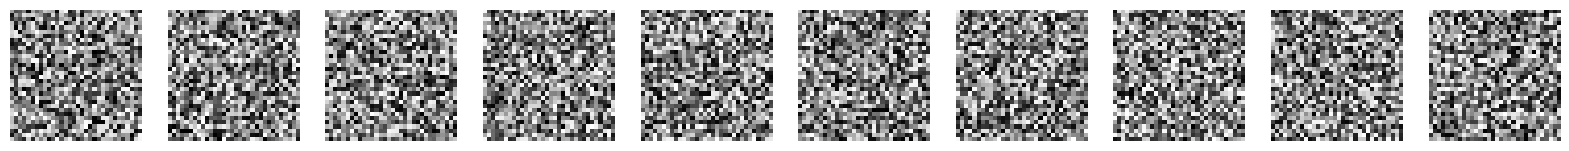

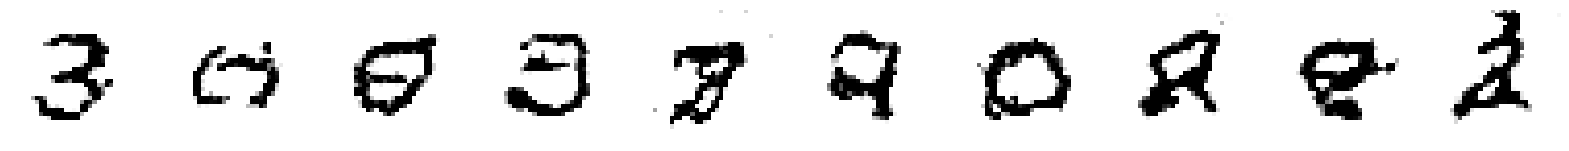

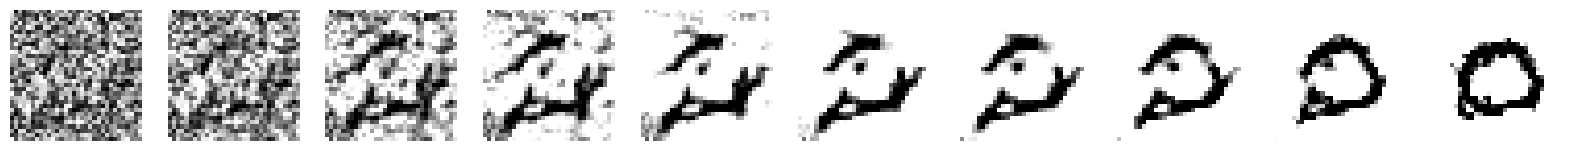

In [11]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

display(start_imgs)

gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

display(gen_img[-1].numpy())

imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))